In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize as mn
import scipy.integrate as spi
import datetime
import random as rnd

In [3]:
confirmed=pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv')

confirmed=confirmed.groupby(['Province_State']).sum()
confirmed=confirmed.iloc[:,5:-2]
confirmed.reset_index(inplace=True)
confirmed.head()

,Province_State,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,...,6/17/20,6/18/20,6/19/20,6/20/20,6/21/20,6/22/20,6/23/20,6/24/20,6/25/20,6/26/20
0,Alabama,0,0,0,0,0,0,0,0,0,...,27312,28206,29002,29549,30021,30454,31097,32064,33206,34183
1,Alaska,0,0,0,0,0,0,0,0,0,...,695,707,720,741,752,758,760,789,813,833
2,American Samoa,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Arizona,0,0,0,0,1,1,1,1,1,...,40937,43445,46910,50127,52591,54599,58378,60190,63281,66659
4,Arkansas,0,0,0,0,0,0,0,0,0,...,13606,13928,14631,15142,15561,16083,16678,17375,18062,18740


In [30]:
deaths=pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv')
#deaths.to_csv('../../Downloads/Pythonstuff/deaths.csv')

### Implementation

In [4]:
with open("../../Downloads/Pythonstuff/Abbreviation.csv", "r") as file_abb:
    LINES = file_abb.readlines()
    a = 2

Name2ab = dict()
for LINE in LINES:
    LINE = LINE.strip()
    res = LINE.split(sep=',')
    Name2ab[res[0]]=res[1]

#Sum field by field of a list
def merge(l1, l2):
    N = len(l1)
    l=list()
    for i in range(0, N):
        l.append(l1[i]+l2[i])
    return l

#Initialization
Deaths = dict()
Confirmed = dict()
Population = dict()

# Process for death
with open("../../Downloads/Pythonstuff/TimeSerie_death.csv", "r") as file_death:
    head = file_death.readline()

    head = head.strip()
    head = head.split(sep=',')
    num_tot = len(head)
    num_date = num_tot -12
    
    Death_dates = head[12:num_tot]

    #Creation of keys and empty fields
    for name in Name2ab:
        Population[Name2ab[name]] = 0;
        Deaths[Name2ab[name]] = [0]*num_date;

    #Filling for each line
    for line in file_death:
        temp = line.split(sep="\"")
        line = temp[0]+temp[2]     #We avoid the comma inside of a field
        line = line.split(sep=',')
        ab = Name2ab.get(line[6])
        if ab is None:
            continue
        
        Population[ab] = Population[ab]+int(line[11])
        Deaths[ab] = merge(Deaths[ab], [int(x) for x in line[12:num_tot]])

In [22]:
class SIR:
    
    def __init__(self,Population):
        self.N=Population
    
    def ODEs1(self,x,beta1,gamma):
        t_init=0
        t_final=len(x)
        t_range=np.arange(t_init,t_final,1)
        beta1=np.array(beta1)
        gamma=np.array(gamma)
        
        def SIR_odes(inp,t,beta1,gamma):
            Y = np.zeros((3))
            V = inp
            Y[0] = - beta1 * V[0] * V[1]                 #S
            Y[1] = beta1 * V[0] * V[1] - gamma * V[1]    #I
            Y[2] = gamma * V[1]                         #R
            return Y
        
        result_fit = spi.odeint(SIR_odes, (self.S0, self.I0,self.R0), t_range,
                                    args=(beta1, gamma))
        S=result_fit[:,0]*self.N
        I=result_fit[:,1]*self.N
        R=result_fit[:,2]*self.N
        
        return S,I,R
    
    
    def ODEs2(self,x,beta1,gamma,beta2,t_star):
        t_init=0
        t_final=len(x)
        t_range=np.arange(t_init,t_final,1)
        
        def f(t):
            h = 1.0/(1.0+ np.exp(-100*t))
            return h
        def beta(t,t1,b1,b2):
            beta = b1*f(t1-t) + b2*f(t-t1) 
            return beta
        gamma = np.array(gamma)
        def SIR_odes(INP, t, beta1, gamma,beta2,t1):
            Y = np.zeros((3))
            V = INP
            Y[0] = - beta(t,t1,beta1,beta2) * V[0] * V[1]                 #S
            Y[1] = beta(t,t1,beta1,beta2) * V[0] * V[1] - gamma * V[1]    #I
            Y[2] = gamma * V[1]                         #R
            return Y
        result_fit = spi.odeint(SIR_odes,(self.S0,self.I0,self.R0), t_range,
                                    args=(beta1, gamma,beta2,t_star))
        
    
        S=result_fit[:,0]*self.N
        I=result_fit[:,1]*self.N
        R=result_fit[:,2]*self.N
        
        return S,I,R
    
    
    def loss1(self,point,x,y):
        res=0
        y=y*self.N
    
        if (self.beta2):
            S,I,R = self.ODEs2(x,point[0],point[1],point[2],point[3])
            res= (np.abs(y-(I+R))).mean()
        else:
            S,I,R=self.ODEs1(x,point[0],point[1])
            res=(np.abs(y-(I+R))).mean()
        return res
    
    
    def generate_print_callback(self):
        
        self.saved_params = { "iteration_number" : 0 }
    
    
        def print_callback(xs):
            if self.saved_params["iteration_number"] % 2 == 0:
                print("{:3} | {}".format(
                    self.saved_params["iteration_number"], xs))
            self.saved_params["iteration_number"] += 1

        return print_callback
    
    
    def fit1(self,x,y,bnd=[(0.0001,0.99),(0.0001,0.99)],beta2=True,init_vals=[0.03,0.05],iters=300,display=True):
        self.x=x
        self.y=y
        self.beta2=beta2
        df=np.array(y)/self.N
        self.I0=df[0]
        self.S0=1-self.I0
        self.R0=0
        
        
        if (self.beta2):
            init_vals= [0.03,0.05,0.6,30]
            bnd=[(0.0001,0.99),(0.0001,0.99),(0.0001,0.99),(x[5],x[-7])]
            opt=mn(self.loss1,init_vals,args=(x,df),method='L-BFGS-B',bounds=bnd,
            callback=self.generate_print_callback(),options={'maxiter':iters,'disp':display})
            self.beta1=opt.x[0]
            self.gamma=opt.x[1]
            self.beta2=opt.x[2]
            self.day_change=opt.x[3]
            self.loss=opt.fun
            
        else:
            opt=mn(self.loss1,init_vals,args=(x,df),method='L-BFGS-B',bounds=bnd,
            callback=self.generate_print_callback(),options={'maxiter':iters,'disp':display})
            self.beta1=opt.x[0]
            self.gamma=opt.x[1]
            self.loss=opt.fun
        
    def predict1(self,x):
        
        if self.beta2:
            S,I,R = self.ODEs2(x,self.beta1,self.gamma,self.beta2,self.day_change)
        else:
            S,I,R = self.ODEs1(x,self.beta1,self.gamma)
        self.ypred = I+R
        self.S = S
        self.I = I
        self.R = R         
        return self.ypred
    
    def getCoef(self):
        if self.beta2:
            return ['beta','beta2','gamma','day_change'], [self.beta1,self.beta2,self.gamma,self.day_change]
        else:
            return ['beta','gamma'], [self.beta1,self.gamma]
        

In [23]:
sirs=[None]*len(Name2ab)
ys=[]
xs=[]
lista_pop=list(Population.values())
lista_states=list(Name2ab)
for i in range(len(lista_states)):
    print(lista_pop[i])
    sirs[i]=SIR(lista_pop[i])
    print('starting collecting confirmed cases for state {}'.format(lista_states[i]))
    nonzero_arr=np.array(confirmed[confirmed.Province_State==lista_states[i]].iloc[:,1:])
    ys.append(nonzero_arr[nonzero_arr>0])
    xs.append(range(1,len(ys[i])+1))
    print('starts fitting for {}'.format(lista_states[i]))
    sirs[i].fit1(xs[i],ys[i],iters=300) 
    print('fitting done for state {}'.format(lista_states[i]))

    
    
    

4903185
starting collecting confirmed cases for state Alabama
starts fitting for Alabama
  0 | [1.0e-04 9.9e-01 1.0e-04 3.0e+01]
  2 | [9.89950546e-01 9.90000000e-01 1.00000000e-04 3.00000000e+01]

/Users/Cristy/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: overflow encountered in exp



  4 | [9.89978508e-01 9.90000000e-01 1.00000000e-04 3.00000000e+01]
  6 | [9.89986581e-01 9.90000000e-01 1.00000000e-04 3.00000000e+01]
fitting done for state Alabama
731545
starting collecting confirmed cases for state Alaska
starts fitting for Alaska
  0 | [1.0e-04 9.9e-01 1.0e-04 1.0e+02]
fitting done for state Alaska
7278717
starting collecting confirmed cases for state Arizona
starts fitting for Arizona
  0 | [1.0e-04 9.9e-01 1.0e-04 3.0e+01]
  2 | [9.9e-01 9.9e-01 1.0e-04 3.0e+01]
  4 | [9.9e-01 9.9e-01 1.0e-04 3.0e+01]
fitting done for state Arizona
3017804
starting collecting confirmed cases for state Arkansas
starts fitting for Arkansas
  0 | [1.0e-04 9.9e-01 1.0e-04 1.0e+02]
  2 | [9.89999959e-01 9.90000000e-01 1.00000000e-04 1.00000000e+02]
fitting done for state Arkansas
39512223
starting collecting confirmed cases for state California
starts fitting for California
  0 | [1.0e-04 9.9e-01 1.0e-04 3.0e+01]
fitting done for state California
5758736
starting collecting confirm

KeyboardInterrupt: 

In [82]:
losses=[sirs[i].loss for i in range(len(sirs))]
betas=[sirs[i].beta for i in range(len(sirs))]
gammas=[sirs[i].gamma for i in range(len(sirs))]

In [87]:
sirs2=[None]*len(Name2ab)
ys2=[]
xs2=[]
lista_pop=list(Population.values())
lista_states=list(Name2ab)
for i in range(len(lista_states)):
    print(lista_pop[i])
    sirs2[i]=SIR(lista_pop[i])
    print('starting collecting confirmed cases for state {}'.format(lista_states[i]))
    nonzero_arr=np.array(confirmed[confirmed.Province_State==lista_states[i]].iloc[:,1:])
    ys2.append(nonzero_arr[nonzero_arr>0])
    xs2.append(range(1,len(ys2[i])+1))
    print('starts fitting for {}'.format(lista_states[i]))
    sirs2[i].fit1(xs2[i],ys2[i],iters=300) 
    print('fitting done for state {}'.format(lista_states[i]))

    

4903185
starting collecting confirmed cases for state Alabama
starts fitting for Alabama
  0 | [0.13025325 0.04478892]
  2 | [0.12955936 0.04490723]
  4 | [0.12958239 0.04491231]
  6 | [0.12958241 0.04491231]
fitting done for state Alabama
731545
starting collecting confirmed cases for state Alaska
starts fitting for Alaska
  0 | [0.10913879 0.04588643]
  2 | [0.10874943 0.0460061 ]
  4 | [0.10876041 0.046011  ]
  6 | [0.10876034 0.04604708]
  8 | [0.10876056 0.04609387]
 10 | [0.10876564 0.04617474]
 12 | [0.1088066  0.04641871]
 14 | [0.1088334 0.0465114]
 16 | [0.1091582  0.04649562]
 18 | [0.10919374 0.04649439]
 20 | [0.13372678 0.07348571]
 22 | [0.19652524 0.14257627]
 24 | [0.19584576 0.14182831]
 26 | [0.19649311 0.14170537]
 28 | [0.19719706 0.14195613]
 30 | [0.19721838 0.14202054]
 32 | [0.19721847 0.14202071]
fitting done for state Alaska
7278717
starting collecting confirmed cases for state Arizona
starts fitting for Arizona
  0 | [0.1181154  0.04541983]
  2 | [0.11597324

 26 | [0.99       0.95696972]
fitting done for state Montana
1934408
starting collecting confirmed cases for state Nebraska
starts fitting for Nebraska
  0 | [0.13428616 0.04457929]
  2 | [0.14061077 0.05077267]
  4 | [0.23605309 0.15317056]
  6 | [0.34318577 0.26466331]
  8 | [0.58223676 0.50769403]
 10 | [0.98331169 0.91508151]
 12 | [0.99       0.91996234]
 14 | [0.99       0.91976416]
 16 | [0.99       0.91976395]
fitting done for state Nebraska
3080156
starting collecting confirmed cases for state Nevada
starts fitting for Nevada
  0 | [0.13134425 0.04473221]
  2 | [0.12998185 0.0448208 ]
  4 | [0.13007845 0.04482906]
  6 | [0.13007845 0.04482906]
fitting done for state Nevada
1359711
starting collecting confirmed cases for state New Hampshire
starts fitting for New Hampshire
  0 | [0.11901616 0.04537301]
  2 | [0.12094455 0.04530376]
  4 | [0.12149064 0.04552481]
  6 | [0.12150107 0.04553097]
  8 | [0.12149992 0.0459062 ]
 10 | [0.12149969 0.04605561]
 12 | [0.12150056 0.04608339

In [114]:

rnd.seed(123)
init_vals=rnd.sample(range(1,9900),200)
betas0=[i/10000 for i in init_vals[:100]]
gammas0=[i/10000 for i in init_vals[100:]]
init_vals=list(zip(betas0,gammas0)) 
#init_vals
#list(init_vals[0])

In [115]:
len(init_vals)

100

In [116]:
losses=[np.zeros(len(Name2ab))]*100
betas=[np.zeros(len(Name2ab))]*100
gammas=[np.zeros(len(Name2ab))]*100

lista_pop=list(Population.values())
lista_states=list(Name2ab)

rnd.seed(123)
init_vals=rnd.sample(range(1,9900),200)
betas0=[i/10000 for i in init_vals[:99]]
gammas0=[i/10000 for i in init_vals[100:]]
init_vals=list(zip(betas0,gammas0)) 

for k in range(len(init_vals)):
    sirs=[None]*len(Name2ab)
    ys=[]
    xs=[]
    print('starting with {}-th initial values :{}'.format(k,init_vals[k]))
    for i in range(len(lista_states)):
        print(lista_pop[i])
        sirs[i]=SIR(lista_pop[i])
        print('starting collecting confirmed cases for state {}'.format(lista_states[i]))
        nonzero_arr=np.array(confirmed[confirmed.Province_State==lista_states[i]].iloc[:,1:])
        ys.append(nonzero_arr[nonzero_arr>0])
        xs.append(range(1,len(ys[i])+1))
        print('starts fitting for {}'.format(lista_states[i]))
        sirs[i].fit1(xs[i],ys[i],init_vals=list(init_vals[k]),iters=300) 
        print('fitting done for state {}'.format(lista_states[i]))
        losses[k][i]=sirs[i].loss
        betas[k][i]=sirs[i].beta
        gammas[k][i]=sirs[i].gamma
 


starting with 0-th initial values :(0.0858, 0.0167)
4903185
starting collecting confirmed cases for state Alabama
starts fitting for Alabama
  0 | [0.10244162 0.01639448]
  2 | [0.10378422 0.01660183]
  4 | [0.10390523 0.01666015]
  6 | [0.10390712 0.01673743]
  8 | [0.10391371 0.0169574 ]
 10 | [0.10392011 0.01686566]
 12 | [0.10396463 0.01672878]
 14 | [0.1039651  0.01679112]
 16 | [0.10396593 0.01696174]
 18 | [0.10399619 0.01718007]
 20 | [0.10411834 0.01757702]
 22 | [0.10412274 0.01758626]
 24 | [0.10475386 0.01760984]
 26 | [0.10475987 0.01761007]
fitting done for state Alabama
731545
starting collecting confirmed cases for state Alaska
starts fitting for Alaska
  0 | [0.0854063  0.02117124]
  2 | [0.08559267 0.02015723]
  4 | [0.08562195 0.02032364]
  6 | [0.08586804 0.02042279]
  8 | [0.08610087 0.02051792]
 10 | [0.08622801 0.02057008]
 12 | [0.08623426 0.02057265]
 14 | [0.08619385 0.02083621]
 16 | [0.08617556 0.02095666]
 18 | [0.08617553 0.02095687]
fitting done for state

 18 | [0.99       0.91349068]
 20 | [0.99       0.91348989]
fitting done for state Mississippi
6626371
starting collecting confirmed cases for state Missouri
starts fitting for Missouri
  0 | [0.10872294 0.01627916]
  2 | [0.10929528 0.01636538]
  4 | [0.10929743 0.01637053]
fitting done for state Missouri
1068778
starting collecting confirmed cases for state Montana
starts fitting for Montana
  0 | [0.08532377 0.02210863]
  2 | [0.08547657 0.02119844]
  4 | [0.0855873  0.02152508]
  6 | [0.13706008 0.07974326]
  8 | [0.14251105 0.08561384]
 10 | [0.20489192 0.1514771 ]
 12 | [0.36178812 0.3170956 ]
 14 | [0.58428079 0.54557342]
 16 | [0.99       0.95862392]
 18 | [0.99      0.9565199]
 20 | [0.99       0.95698484]
 22 | [0.99       0.95696972]
fitting done for state Montana
1934408
starting collecting confirmed cases for state Nebraska
starts fitting for Nebraska
  0 | [0.10777489 0.01629657]
  2 | [0.10855189 0.01710306]
  4 | [0.15530357 0.06806266]
  6 | [0.17955129 0.0943764 ]
  8

 24 | [0.84431933 0.77902185]
 26 | [0.84432455 0.77902941]
fitting done for state Wisconsin
578759
starting collecting confirmed cases for state Wyoming
starts fitting for Wyoming
  0 | [0.08726914 0.01667303]
  2 | [0.08683174 0.01676532]
  4 | [0.08688959 0.01680983]
  6 | [0.10877567 0.04155583]
  8 | [0.13876459 0.0754549 ]
 10 | [0.16585227 0.10513377]
 12 | [0.26498218 0.20894922]
 14 | [0.50526105 0.45716382]
 16 | [0.79686803 0.7546666 ]
 18 | [0.99       0.94899311]
 20 | [0.99       0.94899017]
fitting done for state Wyoming
2933408
starting collecting confirmed cases for state Puerto Rico
starts fitting for Puerto Rico
  0 | [0.09047441 0.01661418]
  2 | [0.09083022 0.01682002]
  4 | [0.09082909 0.01709555]
  6 | [0.09082811 0.01735087]
  8 | [0.09082758 0.0175104 ]
 10 | [0.09082757 0.01751465]
 12 | [0.09116643 0.01748215]
 14 | [0.09139368 0.01746152]
 16 | [0.23263311 0.1700675 ]
 18 | [0.34778059 0.29038205]
 20 | [0.53289869 0.48320369]
 22 | [0.67542018 0.62699629]
 

fitting done for state New Hampshire
8882190
starting collecting confirmed cases for state New Jersey
starts fitting for New Jersey
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.98877642]
  4 | [0.99       0.90335286]
  6 | [0.99       0.90324924]
  8 | [0.99       0.90324919]
fitting done for state New Jersey
2096829
starting collecting confirmed cases for state New Mexico
starts fitting for New Mexico
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.93497494]
  4 | [0.99       0.93533246]
fitting done for state New Mexico
26161672
starting collecting confirmed cases for state New York
starts fitting for New York
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.98997375]
  4 | [0.99       0.89185706]
  6 | [0.99       0.89185124]
fitting done for state New York
10488084
starting collecting confirmed cases for state North Carolina
starts fitting for North Carolina
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.98975272]
  4 | [0.99       0.91232496]
  6 | [0.99       0.91229662]
  8 | [0.99       0.9

  4 | [0.59637519 0.53430263]
  6 | [0.59637524 0.53430261]
fitting done for state Idaho
12671821
starting collecting confirmed cases for state Illinois
starts fitting for Illinois
  0 | [0.61942936 0.54632282]
  2 | [0.614976  0.5482078]
  4 | [0.61506273 0.54818205]
  6 | [0.61506343 0.54818193]
  8 | [0.61506337 0.54818194]
fitting done for state Illinois
6732219
starting collecting confirmed cases for state Indiana
starts fitting for Indiana
  0 | [0.62417282 0.53088351]
  2 | [0.61724226 0.53403374]
  4 | [0.61719666 0.53405526]
fitting done for state Indiana
3155070
starting collecting confirmed cases for state Iowa
starts fitting for Iowa
  0 | [0.49180633 0.43977606]
  2 | [0.50178022 0.43098672]
  4 | [0.50177032 0.43099569]
  6 | [0.50177031 0.43099583]
fitting done for state Iowa
2913314
starting collecting confirmed cases for state Kansas
starts fitting for Kansas
  0 | [0.58071968 0.55845059]
  2 | [0.60164235 0.52990982]
  4 | [0.60167278 0.52987115]
  6 | [0.60167317 0.5

fitting done for state Pennsylvania
1059361
starting collecting confirmed cases for state Rhode Island
starts fitting for Rhode Island
  0 | [0.58559633 0.55030627]
  2 | [0.6008763  0.52955683]
  4 | [0.6008798  0.52955446]
  6 | [0.60087981 0.52955445]
fitting done for state Rhode Island
5148714
starting collecting confirmed cases for state South Carolina
starts fitting for South Carolina
  0 | [0.50512085 0.43276806]
  2 | [0.50467858 0.4331562 ]
  4 | [0.50468426 0.43315139]
fitting done for state South Carolina
884659
starting collecting confirmed cases for state South Dakota
starts fitting for South Dakota
  0 | [0.48106728 0.44925371]
  2 | [0.48808059 0.44307883]
  4 | [0.48804448 0.44312895]
  6 | [0.48804445 0.443129  ]
fitting done for state South Dakota
6829174
starting collecting confirmed cases for state Tennessee
starts fitting for Tennessee
  0 | [0.57733054 0.55394526]
  2 | [0.60154375 0.52144956]
  4 | [0.60147797 0.52154569]
  6 | [0.6014779 0.5215458]
fitting done 

fitting done for state Massachusetts
9986857
starting collecting confirmed cases for state Michigan
starts fitting for Michigan
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.90965706]
  4 | [0.99       0.90974588]
  6 | [0.99       0.90974604]
fitting done for state Michigan
5639632
starting collecting confirmed cases for state Minnesota
starts fitting for Minnesota
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.91446367]
  4 | [0.99       0.91409376]
  6 | [0.99       0.91409327]
fitting done for state Minnesota
2976149
starting collecting confirmed cases for state Mississippi
starts fitting for Mississippi
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.91393368]
  4 | [0.99       0.91349096]
  6 | [0.99       0.91348988]
fitting done for state Mississippi
6626371
starting collecting confirmed cases for state Missouri
starts fitting for Missouri
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.98952369]
  4 | [0.99       0.91952475]
  6 | [0.99       0.91952603]
fitting done for state Missouri
106

  8 | [0.99       0.93529111]
 10 | [0.98999998 0.93529108]
fitting done for state Arizona
3017804
starting collecting confirmed cases for state Arkansas
starts fitting for Arkansas
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.94645831]
  4 | [0.99       0.94483301]
  6 | [0.99       0.94489673]
  8 | [0.99       0.94489667]
fitting done for state Arkansas
39512223
starting collecting confirmed cases for state California
starts fitting for California
  0 | [1.0e-04 9.9e-01]
fitting done for state California
5758736
starting collecting confirmed cases for state Colorado
starts fitting for Colorado
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.98873418]
  4 | [0.99       0.92307182]
  6 | [0.99       0.92268573]
  8 | [0.99       0.92253448]
 10 | [0.99       0.92253381]
fitting done for state Colorado
3565287
starting collecting confirmed cases for state Connecticut
starts fitting for Connecticut
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.98731295]
  4 | [0.99       0.90586617]
  6 | [0.9

  4 | [0.99       0.91996633]
  6 | [0.99      0.9199685]
fitting done for state Ohio
3956971
starting collecting confirmed cases for state Oklahoma
starts fitting for Oklahoma
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.98565659]
  4 | [0.99       0.92742431]
  6 | [0.99       0.92742456]
  8 | [0.98999999 0.92742456]
fitting done for state Oklahoma
4217737
starting collecting confirmed cases for state Oregon
starts fitting for Oregon
  0 | [1.0e-04 9.9e-01]
  2 | [0.99      0.9828757]
  4 | [0.99       0.93577027]
  6 | [0.99     0.936055]
  8 | [0.99       0.93605303]
fitting done for state Oregon
12801989
starting collecting confirmed cases for state Pennsylvania
starts fitting for Pennsylvania
  0 | [1.0e-04 9.9e-01]
  2 | [0.99      0.9856067]
  4 | [0.99       0.91135433]
fitting done for state Pennsylvania
1059361
starting collecting confirmed cases for state Rhode Island
starts fitting for Rhode Island
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.92330344]
  4 | [0.99       0.9

  4 | [0.38578869 0.31205756]
  6 | [0.38578869 0.31205755]
fitting done for state Iowa
2913314
starting collecting confirmed cases for state Kansas
starts fitting for Kansas
  0 | [0.38794073 0.31093576]
  2 | [0.38740595 0.31125799]
  4 | [0.38736711 0.31137992]
  6 | [0.38736756 0.31138698]
  8 | [0.38736757 0.311387  ]
fitting done for state Kansas
4467673
starting collecting confirmed cases for state Kentucky
starts fitting for Kentucky
  0 | [0.38786205 0.31097638]
  2 | [0.38712441 0.31139444]
  4 | [0.38715499 0.31156232]
  6 | [0.38719839 0.31166393]
  8 | [0.38720954 0.31166394]
 10 | [0.3873071  0.31166371]
 12 | [0.38729711 0.31166423]
 14 | [0.38726917 0.31166922]
 16 | [0.38723218 0.31169354]
 18 | [0.38723093 0.31169742]
 20 | [0.38734352 0.31169747]
 22 | [0.38733774 0.31169759]
 24 | [0.38732266 0.31169874]
 26 | [0.38728878 0.31170765]
 28 | [0.38726145 0.31172877]
 30 | [0.38731733 0.31172877]
 32 | [0.38737853 0.31172895]
 34 | [0.38741558 0.31173355]
 36 | [0.38754

  6 | [0.39285675 0.30842913]
  8 | [0.64084917 0.5624491 ]
 10 | [0.67242881 0.59479614]
 12 | [0.67248639 0.59485511]
 14 | [0.67281934 0.59381703]
 16 | [0.67275976 0.59400499]
 18 | [0.67275948 0.59400648]
fitting done for state Tennessee
28995881
starting collecting confirmed cases for state Texas
starts fitting for Texas
  0 | [0.39106863 0.30932087]
  2 | [0.39282895 0.30841541]
  4 | [0.39283014 0.30841492]
fitting done for state Texas
3205958
starting collecting confirmed cases for state Utah
starts fitting for Utah
  0 | [0.38843671 0.31067969]
  2 | [0.38889576 0.31045539]
  4 | [0.38888869 0.31046052]
fitting done for state Utah
623989
starting collecting confirmed cases for state Vermont
starts fitting for Vermont
  0 | [0.36365071 0.3234764 ]
  2 | [0.37084729 0.31976092]
fitting done for state Vermont
8535519
starting collecting confirmed cases for state Virginia
starts fitting for Virginia
  0 | [0.3867931  0.31152827]
  2 | [0.39356531 0.3080484 ]
  4 | [0.39361232 0.3

  6 | [0.46474122 0.37612566]
fitting done for state Michigan
5639632
starting collecting confirmed cases for state Minnesota
starts fitting for Minnesota
  0 | [0.53625119 0.4608592 ]
  2 | [0.5390743  0.45800257]
  4 | [0.5393612  0.45772592]
  6 | [0.53936113 0.45772599]
  8 | [0.53936113 0.45772599]
fitting done for state Minnesota
2976149
starting collecting confirmed cases for state Mississippi
starts fitting for Mississippi
  0 | [0.53843944 0.46256349]
  2 | [0.54205181 0.45887985]
  4 | [0.54166861 0.45928467]
  6 | [0.54166864 0.45928464]
fitting done for state Mississippi
6626371
starting collecting confirmed cases for state Missouri
starts fitting for Missouri
  0 | [0.53602627 0.46444283]
  2 | [0.53852849 0.46189121]
  4 | [0.53852608 0.46189492]
fitting done for state Missouri
1068778
starting collecting confirmed cases for state Montana
starts fitting for Montana
  0 | [0.48755125 0.47267323]
  2 | [0.50179082 0.45931522]
  4 | [0.50178606 0.45932315]
  6 | [0.50178605 

  8 | [0.99       0.94489667]
fitting done for state Arkansas
39512223
starting collecting confirmed cases for state California
starts fitting for California
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.92946634]
  4 | [0.99       0.92979113]
  6 | [0.99       0.92978627]
fitting done for state California
5758736
starting collecting confirmed cases for state Colorado
starts fitting for Colorado
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.98976917]
  4 | [0.99       0.92261059]
  6 | [0.99       0.92253382]
fitting done for state Colorado
3565287
starting collecting confirmed cases for state Connecticut
starts fitting for Connecticut
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.98947134]
  4 | [0.99       0.90653321]
  6 | [0.99       0.90669071]
  8 | [0.98999967 0.90669074]
fitting done for state Connecticut
973764
starting collecting confirmed cases for state Delaware
starts fitting for Delaware
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.92123325]
  4 | [0.99       0.92126446]
  6 | [

  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.98915086]
  4 | [0.99       0.91074489]
fitting done for state Pennsylvania
1059361
starting collecting confirmed cases for state Rhode Island
starts fitting for Rhode Island
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.92313299]
  4 | [0.99       0.92281581]
  6 | [0.99       0.92281522]
fitting done for state Rhode Island
5148714
starting collecting confirmed cases for state South Carolina
starts fitting for South Carolina
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.98976335]
  4 | [0.99       0.92547534]
  6 | [0.99       0.92556354]
  8 | [0.99       0.92555823]
fitting done for state South Carolina
884659
starting collecting confirmed cases for state South Dakota
starts fitting for South Dakota
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.95324077]
  4 | [0.99       0.95356484]
  6 | [0.99       0.95359729]
  8 | [0.98999999 0.95359736]
fitting done for state South Dakota
6829174
starting collecting confirmed cases for state Tennessee
star

  4 | [0.99       0.91774138]
  6 | [0.99      0.9180783]
  8 | [0.99       0.91808498]
fitting done for state Maryland
6892503
starting collecting confirmed cases for state Massachusetts
starts fitting for Massachusetts
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.98872767]
  4 | [0.99       0.92337754]
  6 | [0.99       0.92337746]
fitting done for state Massachusetts
9986857
starting collecting confirmed cases for state Michigan
starts fitting for Michigan
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.98934533]
  4 | [0.99       0.90970615]
  6 | [0.99       0.90974547]
  8 | [0.99       0.90974604]
fitting done for state Michigan
5639632
starting collecting confirmed cases for state Minnesota
starts fitting for Minnesota
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.98911043]
  4 | [0.99       0.91415209]
  6 | [0.99       0.91409332]
  8 | [0.99       0.91409327]
fitting done for state Minnesota
2976149
starting collecting confirmed cases for state Mississippi
starts fitting for Missis

  6 | [0.99       0.93528796]
  8 | [0.99      0.9352911]
fitting done for state Arizona
3017804
starting collecting confirmed cases for state Arkansas
starts fitting for Arkansas
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.94438796]
  4 | [0.99       0.94489942]
  6 | [0.99       0.94489674]
  8 | [0.99       0.94489667]
fitting done for state Arkansas
39512223
starting collecting confirmed cases for state California
starts fitting for California
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.98824505]
  4 | [0.99       0.92971672]
  6 | [0.99       0.92978617]
fitting done for state California
5758736
starting collecting confirmed cases for state Colorado
starts fitting for Colorado
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.98974046]
  4 | [0.99       0.92285312]
  6 | [0.99       0.92254695]
  8 | [0.99       0.92253381]
fitting done for state Colorado
3565287
starting collecting confirmed cases for state Connecticut
starts fitting for Connecticut
  0 | [1.0e-04 9.9e-01]
  2 | [0.99 

  8 | [0.99       0.92742457]
fitting done for state Oklahoma
4217737
starting collecting confirmed cases for state Oregon
starts fitting for Oregon
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.98857344]
  4 | [0.99       0.93604427]
  6 | [0.99       0.93605302]
  8 | [0.98999999 0.93605302]
fitting done for state Oregon
12801989
starting collecting confirmed cases for state Pennsylvania
starts fitting for Pennsylvania
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.98904787]
  4 | [0.99       0.91092515]
fitting done for state Pennsylvania
1059361
starting collecting confirmed cases for state Rhode Island
starts fitting for Rhode Island
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.92289165]
  4 | [0.99       0.92281534]
  6 | [0.99       0.92281523]
fitting done for state Rhode Island
5148714
starting collecting confirmed cases for state South Carolina
starts fitting for South Carolina
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.98973396]
  4 | [0.99    0.92567]
  6 | [0.99       0.9255583

  4 | [0.99      0.9177554]
  6 | [0.99       0.91802755]
  8 | [0.99       0.91808498]
fitting done for state Maryland
6892503
starting collecting confirmed cases for state Massachusetts
starts fitting for Massachusetts
  0 | [1.0e-04 9.9e-01]
  2 | [0.99      0.9732373]
  4 | [0.99       0.92289012]
  6 | [0.99      0.9233775]
  8 | [0.99       0.92337746]
fitting done for state Massachusetts
9986857
starting collecting confirmed cases for state Michigan
starts fitting for Michigan
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.98384496]
  4 | [0.99       0.90965124]
  6 | [0.99       0.90974577]
  8 | [0.99       0.90974604]
fitting done for state Michigan
5639632
starting collecting confirmed cases for state Minnesota
starts fitting for Minnesota
  0 | [1.0e-04 9.9e-01]
  2 | [0.99      0.9811552]
  4 | [0.99       0.91409386]
  6 | [0.99       0.91409327]
  8 | [0.98999999 0.91409327]
fitting done for state Minnesota
2976149
starting collecting confirmed cases for state Mississippi
s

fitting done for state Alabama
731545
starting collecting confirmed cases for state Alaska
starts fitting for Alaska
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.95534451]
  4 | [0.99       0.95546689]
  6 | [0.99       0.95546296]
  8 | [0.99       0.95546295]
fitting done for state Alaska
7278717
starting collecting confirmed cases for state Arizona
starts fitting for Arizona
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.98619459]
  4 | [0.99       0.93517182]
  6 | [0.99       0.93530041]
  8 | [0.99       0.93529095]
 10 | [0.99      0.9352911]
fitting done for state Arizona
3017804
starting collecting confirmed cases for state Arkansas
starts fitting for Arkansas
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.94684784]
  4 | [0.99       0.94490518]
  6 | [0.99       0.94489667]
fitting done for state Arkansas
39512223
starting collecting confirmed cases for state California
starts fitting for California
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.98125273]
  4 | [0.99       0.92973119]


  4 | [0.99       0.93543207]
fitting done for state North Dakota
11689100
starting collecting confirmed cases for state Ohio
starts fitting for Ohio
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.98851956]
  4 | [0.99       0.91996744]
  6 | [0.99       0.91996849]
  8 | [0.99      0.9199685]
fitting done for state Ohio
3956971
starting collecting confirmed cases for state Oklahoma
starts fitting for Oklahoma
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.98795489]
  4 | [0.99       0.92741195]
  6 | [0.99       0.92742462]
  8 | [0.98999999 0.92742456]
fitting done for state Oklahoma
4217737
starting collecting confirmed cases for state Oregon
starts fitting for Oregon
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.98678459]
  4 | [0.99      0.9360522]
  6 | [0.99       0.93605303]
fitting done for state Oregon
12801989
starting collecting confirmed cases for state Pennsylvania
starts fitting for Pennsylvania
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.98790612]
  4 | [0.99       0.91097092]


  4 | [0.16874589 0.09312526]
fitting done for state Illinois
6732219
starting collecting confirmed cases for state Indiana
starts fitting for Indiana
  0 | [0.18570414 0.09120435]
  2 | [0.18572085 0.09120273]
  4 | [0.18572078 0.09120274]
fitting done for state Indiana
3155070
starting collecting confirmed cases for state Iowa
starts fitting for Iowa
  0 | [0.17637025 0.09226162]
  2 | [0.17451857 0.09249427]
  4 | [0.17441455 0.092507  ]
  6 | [0.17441412 0.09250727]
  8 | [0.17441411 0.09250726]
fitting done for state Iowa
2913314
starting collecting confirmed cases for state Kansas
starts fitting for Kansas
  0 | [0.17864744 0.09200368]
  2 | [0.1767586  0.09223597]
  4 | [0.17661206 0.09226713]
  6 | [0.17661511 0.09226734]
  8 | [0.17661511 0.09226733]
fitting done for state Kansas
4467673
starting collecting confirmed cases for state Kentucky
starts fitting for Kentucky
  0 | [0.17850259 0.09202008]
  2 | [0.17613772 0.09230444]
  4 | [0.17604667 0.09231942]
  6 | [0.17604695 0

  0 | [0.18331712 0.09147473]
  2 | [0.18302135 0.09151293]
  4 | [0.18304282 0.09153541]
  6 | [0.23057355 0.1420521 ]
  8 | [0.24115221 0.15329398]
 10 | [0.2408639  0.15296869]
 12 | [0.30277414 0.21770055]
 14 | [0.3209224  0.23490744]
 16 | [0.62700598 0.54841482]
 18 | [0.99       0.91420489]
 20 | [0.99       0.91472254]
 22 | [0.99       0.91471625]
fitting done for state Tennessee
28995881
starting collecting confirmed cases for state Texas
starts fitting for Texas
  0 | [0.18345341 0.09145929]
  2 | [0.18323415 0.09148537]
  4 | [0.18323406 0.0914854 ]
fitting done for state Texas
3205958
starting collecting confirmed cases for state Utah
starts fitting for Utah
  0 | [0.17953783 0.09190282]
  2 | [0.17856277 0.09206984]
  4 | [0.17864158 0.0920816 ]
  6 | [0.17864166 0.09208161]
fitting done for state Utah
623989
starting collecting confirmed cases for state Vermont
starts fitting for Vermont
  0 | [0.15574708 0.09459765]
  2 | [0.15557932 0.09463891]
  4 | [0.1555828  0.094

fitting done for state Maryland
6892503
starting collecting confirmed cases for state Massachusetts
starts fitting for Massachusetts
  0 | [0.63605751 0.59307136]
  2 | [0.64586517 0.57665191]
  4 | [0.64586509 0.57665205]
fitting done for state Massachusetts
9986857
starting collecting confirmed cases for state Michigan
starts fitting for Michigan
  0 | [0.56409771 0.48897549]
  2 | [0.56925999 0.48305978]
  4 | [0.56933985 0.48297797]
  6 | [0.56933999 0.48297785]
fitting done for state Michigan
5639632
starting collecting confirmed cases for state Minnesota
starts fitting for Minnesota
  0 | [0.56795244 0.51809824]
  2 | [0.58186078 0.50102853]
  4 | [0.6278889  0.54818198]
  6 | [0.73380463 0.656567  ]
  8 | [0.85975159 0.78437914]
 10 | [0.99       0.91438138]
 12 | [0.99       0.91409351]
 14 | [0.99       0.91409327]
fitting done for state Minnesota
2976149
starting collecting confirmed cases for state Mississippi
starts fitting for Mississippi
  0 | [0.56139653 0.52692699]
  2 

  0 | [0.45917398 0.40179311]
  2 | [0.46652672 0.39624309]
  4 | [0.46643007 0.3963206 ]
  6 | [0.46643008 0.39632057]
fitting done for state Alabama
731545
starting collecting confirmed cases for state Alaska
starts fitting for Alaska
  0 | [0.44968333 0.40897499]
  2 | [0.45261776 0.40677446]
  4 | [0.4522885  0.40705376]
  6 | [0.45228959 0.40705333]
  8 | [0.45228958 0.40705332]
fitting done for state Alaska
7278717
starting collecting confirmed cases for state Arizona
starts fitting for Arizona
  0 | [0.46152528 0.40001381]
  2 | [0.46090526 0.40048481]
  4 | [0.46087045 0.40051259]
  6 | [0.46087045 0.40051258]
fitting done for state Arizona
3017804
starting collecting confirmed cases for state Arkansas
starts fitting for Arkansas
  0 | [0.45527609 0.40474277]
  2 | [0.45784846 0.40285786]
  4 | [0.45789546 0.40284902]
fitting done for state Arkansas
39512223
starting collecting confirmed cases for state California
starts fitting for California
  0 | [0.46370946 0.39836097]
  2 

  0 | [0.48299727 0.38376526]
  2 | [0.4856058  0.38179885]
  4 | [0.48561116 0.38179496]
fitting done for state New York
10488084
starting collecting confirmed cases for state North Carolina
starts fitting for North Carolina
  0 | [0.47027233 0.39339463]
  2 | [0.47457416 0.39014535]
  4 | [0.47460374 0.39012469]
  6 | [0.47460373 0.39012471]
fitting done for state North Carolina
762062
starting collecting confirmed cases for state North Dakota
starts fitting for North Dakota
  0 | [0.45229349 0.4069998 ]
  2 | [0.46234246 0.39941367]
  4 | [0.46257647 0.39930261]
  6 | [0.46257878 0.39930213]
  8 | [0.46257878 0.39930212]
fitting done for state North Dakota
11689100
starting collecting confirmed cases for state Ohio
starts fitting for Ohio
  0 | [0.46858962 0.39466799]
  2 | [0.47074037 0.39304937]
  4 | [0.47082889 0.39299966]
  6 | [0.47081601 0.39301187]
  8 | [0.47081597 0.39301191]
fitting done for state Ohio
3956971
starting collecting confirmed cases for state Oklahoma
starts 

  8 | [0.99       0.93419897]
 10 | [0.99       0.93427752]
 12 | [0.99      0.9342787]
fitting done for state Idaho
12671821
starting collecting confirmed cases for state Illinois
starts fitting for Illinois
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.92609238]
  4 | [0.99       0.92606833]
  6 | [0.99       0.92606868]
fitting done for state Illinois
6732219
starting collecting confirmed cases for state Indiana
starts fitting for Indiana
  0 | [1.0e-04 9.9e-01]
  2 | [0.99      0.9888395]
  4 | [0.98998705 0.91109793]
  6 | [0.98998692 0.91106006]
fitting done for state Indiana
3155070
starting collecting confirmed cases for state Iowa
starts fitting for Iowa
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.92602266]
  4 | [0.99       0.92618191]
  6 | [0.98999999 0.926182  ]
  8 | [0.98999994 0.92618194]
fitting done for state Iowa
2913314
starting collecting confirmed cases for state Kansas
starts fitting for Kansas
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.98936693]
  4 | [0.99      

  6 | [0.99       0.91359085]
fitting done for state Virginia
7614893
starting collecting confirmed cases for state Washington
starts fitting for Washington
  0 | [1.0e-04 9.9e-01]
  2 | [0.98999829 0.99      ]
  4 | [0.99       0.93915641]
  6 | [0.99       0.93972182]
  8 | [0.99       0.93964639]
 10 | [0.99       0.93964627]
fitting done for state Washington
1792147
starting collecting confirmed cases for state West Virginia
starts fitting for West Virginia
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.93545983]
  4 | [0.99       0.93566801]
  6 | [0.99       0.93581329]
  8 | [0.99       0.93589031]
 10 | [0.99       0.93589083]
fitting done for state West Virginia
5822434
starting collecting confirmed cases for state Wisconsin
starts fitting for Wisconsin
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.98912996]
  4 | [0.99       0.92634663]
  6 | [0.99       0.92630238]
fitting done for state Wisconsin
578759
starting collecting confirmed cases for state Wyoming
starts fitting for Wyo

  4 | [0.99       0.92526351]
  6 | [0.99       0.92526282]
  8 | [0.99       0.92526282]
fitting done for state Nevada
1359711
starting collecting confirmed cases for state New Hampshire
starts fitting for New Hampshire
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.93537309]
  4 | [0.99       0.93548369]
  6 | [0.98999999 0.93548372]
fitting done for state New Hampshire
8882190
starting collecting confirmed cases for state New Jersey
starts fitting for New Jersey
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.90365703]
  4 | [0.99       0.90324924]
  6 | [0.99       0.90324919]
fitting done for state New Jersey
2096829
starting collecting confirmed cases for state New Mexico
starts fitting for New Mexico
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.93547409]
  4 | [0.99       0.93533346]
  6 | [0.99       0.93533247]
fitting done for state New Mexico
26161672
starting collecting confirmed cases for state New York
starts fitting for New York
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.989725

fitting done for state District of Columbia
21477737
starting collecting confirmed cases for state Florida
starts fitting for Florida
  0 | [0.64251663 0.5566537 ]
  2 | [0.6427298  0.55631713]
  4 | [0.64273138 0.55631484]
fitting done for state Florida
10617423
starting collecting confirmed cases for state Georgia
starts fitting for Georgia
  0 | [0.63903099 0.56223656]
  2 | [0.63927351 0.5618829 ]
  4 | [0.63939388 0.56184359]
  6 | [0.63939871 0.56184372]
  8 | [0.63939872 0.56184371]
fitting done for state Georgia
1415872
starting collecting confirmed cases for state Hawaii
starts fitting for Hawaii
  0 | [0.62632205 0.58259207]
  2 | [0.62450611 0.58552169]
  4 | [0.62457616 0.58542243]
  6 | [0.62457616 0.58542242]
fitting done for state Hawaii
1787065
starting collecting confirmed cases for state Idaho
starts fitting for Idaho
  0 | [0.63403554 0.57023762]
  2 | [0.63302258 0.57187668]
  4 | [0.6330942  0.57176759]
  6 | [0.63309419 0.5717677 ]
  8 | [0.63309419 0.57176769]
fi

  2 | [0.63998634 0.56070718]
  4 | [0.63998618 0.56070749]
fitting done for state Tennessee
28995881
starting collecting confirmed cases for state Texas
starts fitting for Texas
  0 | [0.64053493 0.55982774]
  2 | [0.64011905 0.56050856]
  4 | [0.64008717 0.56056701]
  6 | [0.64008717 0.560567  ]
  8 | [0.64008717 0.560567  ]
fitting done for state Texas
3205958
starting collecting confirmed cases for state Utah
starts fitting for Utah
  0 | [0.63772512 0.56432812]
  2 | [0.63776596 0.56426275]
  4 | [0.63776611 0.56426251]
fitting done for state Utah
623989
starting collecting confirmed cases for state Vermont
starts fitting for Vermont
  0 | [0.62697708 0.58154294]
  2 | [0.62684641 0.58176173]
  4 | [0.62684676 0.5817616 ]
fitting done for state Vermont
8535519
starting collecting confirmed cases for state Virginia
starts fitting for Virginia
  0 | [0.6404362  0.55998587]
  2 | [0.64038744 0.56006429]
  4 | [0.64038737 0.5600644 ]
fitting done for state Virginia
7614893
starting co

  4 | [0.99       0.91349509]
  6 | [0.99       0.91348988]
fitting done for state Mississippi
6626371
starting collecting confirmed cases for state Missouri
starts fitting for Missouri
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.98860931]
  4 | [0.99      0.9195199]
  6 | [0.99       0.91952603]
fitting done for state Missouri
1068778
starting collecting confirmed cases for state Montana
starts fitting for Montana
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.95700433]
  4 | [0.99       0.95696972]
fitting done for state Montana
1934408
starting collecting confirmed cases for state Nebraska
starts fitting for Nebraska
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.98821618]
  4 | [0.99       0.91990701]
  6 | [0.99       0.91976395]
fitting done for state Nebraska
3080156
starting collecting confirmed cases for state Nevada
starts fitting for Nevada
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.98884186]
  4 | [0.99       0.92526308]
  6 | [0.99       0.92526282]
fitting done for state Nevad

  2 | [0.61868275 0.53044539]
  4 | [0.61868269 0.53044543]
  6 | [0.61868269 0.53044543]
fitting done for state Connecticut
973764
starting collecting confirmed cases for state Delaware
starts fitting for Delaware
  0 | [0.60070259 0.56603948]
  2 | [0.61645261 0.54320125]
  4 | [0.61647069 0.54327703]
fitting done for state Delaware
705749
starting collecting confirmed cases for state District of Columbia
starts fitting for District of Columbia
  0 | [0.55629352 0.52768806]
  2 | [0.56160037 0.52126887]
  4 | [0.5630423  0.52285008]
  6 | [0.67195683 0.63207581]
  8 | [0.86447367 0.83126985]
 10 | [0.99       0.95616641]
 12 | [0.99       0.95599697]
 14 | [0.99       0.95599704]
fitting done for state District of Columbia
21477737
starting collecting confirmed cases for state Florida
starts fitting for Florida
  0 | [0.60116684 0.55646054]
  2 | [0.61846359 0.53171308]
  4 | [0.61848599 0.53168325]
  6 | [0.61848601 0.53168321]
fitting done for state Florida
10617423
starting collec

  2 | [0.60224146 0.54295974]
  4 | [0.60224055 0.5429614 ]
  6 | [0.60224055 0.5429614 ]
fitting done for state Oregon
12801989
starting collecting confirmed cases for state Pennsylvania
starts fitting for Pennsylvania
  0 | [0.58242607 0.49589877]
  2 | [0.58119618 0.4974052 ]
  4 | [0.58130366 0.49727544]
  6 | [0.58130371 0.49727539]
fitting done for state Pennsylvania
1059361
starting collecting confirmed cases for state Rhode Island
starts fitting for Rhode Island
  0 | [0.60435198 0.54326386]
  2 | [0.60847294 0.53748026]
  4 | [0.60857183 0.53737278]
  6 | [0.60857217 0.53737259]
fitting done for state Rhode Island
5148714
starting collecting confirmed cases for state South Carolina
starts fitting for South Carolina
  0 | [0.57461236 0.50540387]
  2 | [0.57501129 0.50492745]
  4 | [0.57501007 0.50492912]
fitting done for state South Carolina
884659
starting collecting confirmed cases for state South Dakota
starts fitting for South Dakota
  0 | [0.55828381 0.52526695]
  2 | [0.5

fitting done for state Kansas
4467673
starting collecting confirmed cases for state Kentucky
starts fitting for Kentucky
  0 | [0.67570006 0.61372651]
  2 | [0.67867812 0.60794708]
  4 | [0.67846849 0.60836708]
  6 | [0.67844336 0.60841707]
fitting done for state Kentucky
4648794
starting collecting confirmed cases for state Louisiana
starts fitting for Louisiana
  0 | [0.65336353 0.59380654]
  2 | [0.65773796 0.5861012 ]
  4 | [0.65773116 0.5861151 ]
fitting done for state Louisiana
1344212
starting collecting confirmed cases for state Maine
starts fitting for Maine
  0 | [0.67093226 0.61900782]
  2 | [0.67278691 0.6154303 ]
  4 | [0.67275066 0.61551231]
  6 | [0.67275062 0.61551242]
fitting done for state Maine
6045680
starting collecting confirmed cases for state Maryland
starts fitting for Maryland
  0 | [0.68801658 0.60360176]
  2 | [0.67952084 0.60379354]
  4 | [0.67960674 0.60379265]
  6 | [0.67960678 0.60379265]
fitting done for state Maryland
6892503
starting collecting confir

fitting done for state Wyoming
2933408
starting collecting confirmed cases for state Puerto Rico
starts fitting for Puerto Rico
  0 | [0.61882512 0.59528778]
  2 | [0.62905007 0.57889284]
  4 | [0.62905007 0.57889283]
fitting done for state Puerto Rico
starting with 21-th initial values :(0.7148, 0.1204)
4903185
starting collecting confirmed cases for state Alabama
starts fitting for Alabama
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.98907606]
  4 | [0.99       0.92826849]
  6 | [0.99       0.92826815]
fitting done for state Alabama
731545
starting collecting confirmed cases for state Alaska
starts fitting for Alaska
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.95458864]
  4 | [0.99      0.9555412]
  6 | [0.99       0.95546316]
  8 | [0.98999999 0.95546295]
fitting done for state Alaska
7278717
starting collecting confirmed cases for state Arizona
starts fitting for Arizona
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.97649606]
  4 | [0.99      0.9349214]
  6 | [0.99       0.93531536]
 

  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.98984287]
  4 | [0.99       0.89186759]
  6 | [0.99       0.89185125]
fitting done for state New York
10488084
starting collecting confirmed cases for state North Carolina
starts fitting for North Carolina
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.91253905]
  4 | [0.99       0.91229733]
  6 | [0.99       0.91229565]
fitting done for state North Carolina
762062
starting collecting confirmed cases for state North Dakota
starts fitting for North Dakota
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.93561182]
  4 | [0.99       0.93543229]
fitting done for state North Dakota
11689100
starting collecting confirmed cases for state Ohio
starts fitting for Ohio
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.98542457]
  4 | [0.99       0.91996843]
  6 | [0.99      0.9199685]
fitting done for state Ohio
3956971
starting collecting confirmed cases for state Oklahoma
starts fitting for Oklahoma
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.98359325]
  4 | [0.99

  4 | [0.76795439 0.6905919 ]
  6 | [0.76795646 0.69059553]
  8 | [0.76804074 0.69059514]
 10 | [0.76808874 0.69059504]
 12 | [0.76807515 0.69059647]
 14 | [0.76804696 0.69060781]
 16 | [0.76802743 0.69066134]
 18 | [0.76803191 0.69067202]
 20 | [0.76810917 0.69067068]
 22 | [0.76816025 0.69067119]
 24 | [0.76812102 0.69069721]
 26 | [0.76812247 0.69076379]
 28 | [0.76812258 0.69076394]
fitting done for state Tennessee
28995881
starting collecting confirmed cases for state Texas
starts fitting for Texas
  0 | [0.57374235 0.51363196]
  2 | [0.58288907 0.50235833]
  4 | [0.58288069 0.50236969]
fitting done for state Texas
3205958
starting collecting confirmed cases for state Utah
starts fitting for Utah
  0 | [0.75868862 0.71959161]
  2 | [0.76657098 0.69508988]
  4 | [0.76657133 0.6950888 ]
fitting done for state Utah
623989
starting collecting confirmed cases for state Vermont
starts fitting for Vermont
  0 | [0.74788984 0.72721081]
  2 | [0.75351659 0.7107774 ]
  4 | [0.75564051 0.712

fitting done for state Michigan
5639632
starting collecting confirmed cases for state Minnesota
starts fitting for Minnesota
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.98881672]
  4 | [0.99       0.91422043]
  6 | [0.99       0.91409334]
  8 | [0.98999999 0.91409327]
fitting done for state Minnesota
2976149
starting collecting confirmed cases for state Mississippi
starts fitting for Mississippi
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.98977529]
  4 | [0.99      0.9135009]
  6 | [0.99       0.91348989]
  8 | [0.99       0.91348989]
fitting done for state Mississippi
6626371
starting collecting confirmed cases for state Missouri
starts fitting for Missouri
  0 | [1.0e-04 9.9e-01]
  2 | [0.99      0.9896271]
  4 | [0.99       0.91953092]
  6 | [0.99       0.91952603]
fitting done for state Missouri
1068778
starting collecting confirmed cases for state Montana
starts fitting for Montana
  0 | [1.0e-04 9.9e-01]
  2 | [0.99      0.9572631]
  4 | [0.99       0.95696976]
  6 | [0.99       

starts fitting for California
  0 | [1.0e-04 9.9e-01]
fitting done for state California
5758736
starting collecting confirmed cases for state Colorado
starts fitting for Colorado
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.98758492]
  4 | [0.99      0.9225669]
  6 | [0.99       0.92253382]
fitting done for state Colorado
3565287
starting collecting confirmed cases for state Connecticut
starts fitting for Connecticut
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.98488195]
  4 | [0.99       0.90660886]
  6 | [0.99       0.90669102]
  8 | [0.99       0.90669108]
fitting done for state Connecticut
973764
starting collecting confirmed cases for state Delaware
starts fitting for Delaware
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.92124067]
  4 | [0.99       0.92126465]
  6 | [0.99       0.92126447]
fitting done for state Delaware
705749
starting collecting confirmed cases for state District of Columbia
starts fitting for District of Columbia
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.9567299

  8 | [0.98999999 0.92281522]
fitting done for state Rhode Island
5148714
starting collecting confirmed cases for state South Carolina
starts fitting for South Carolina
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.98755208]
  4 | [0.99       0.92561434]
  6 | [0.99       0.92555828]
  8 | [0.99       0.92555822]
fitting done for state South Carolina
884659
starting collecting confirmed cases for state South Dakota
starts fitting for South Dakota
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.95336059]
  4 | [0.99       0.95359755]
  6 | [0.99       0.95359736]
  8 | [0.98999999 0.95359736]
fitting done for state South Dakota
6829174
starting collecting confirmed cases for state Tennessee
starts fitting for Tennessee
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.98581786]
  4 | [0.99       0.91491825]
  6 | [0.99       0.91471626]
  8 | [0.98999999 0.91471624]
fitting done for state Tennessee
28995881
starting collecting confirmed cases for state Texas
starts fitting for Texas
  0 | [1.0e-04 

  6 | [0.42025271 0.34445283]
  8 | [0.44282196 0.36859295]
 10 | [0.85140941 0.7847654 ]
 12 | [0.99       0.92361456]
 14 | [0.99       0.92332737]
fitting done for state Kansas
4467673
starting collecting confirmed cases for state Kentucky
starts fitting for Kentucky
  0 | [0.41543016 0.34681073]
  2 | [0.41937244 0.34443921]
  4 | [0.41959242 0.34440787]
  6 | [0.41971404 0.34440956]
  8 | [0.4197215  0.34440543]
fitting done for state Kentucky
4648794
starting collecting confirmed cases for state Louisiana
starts fitting for Louisiana
  0 | [0.41003641 0.35006546]
  2 | [0.42018961 0.34395285]
  4 | [0.42050096 0.34384263]
  6 | [0.42050176 0.34384263]
fitting done for state Louisiana
1344212
starting collecting confirmed cases for state Maine
starts fitting for Maine
  0 | [0.40931014 0.35050372]
  2 | [0.41195465 0.34897263]
  4 | [0.41221461 0.34896963]
  6 | [0.41228828 0.34898575]
  8 | [0.49574012 0.43623448]
 10 | [0.47021102 0.40887958]
 12 | [0.73010822 0.67564725]
 14 | 

 20 | [0.99       0.95696973]
 22 | [0.98999999 0.95696972]
fitting done for state Montana
1934408
starting collecting confirmed cases for state Nebraska
starts fitting for Nebraska
  0 | [0.45526821 0.40043874]
  2 | [0.46822161 0.39077109]
  4 | [0.46825821 0.39074477]
  6 | [0.46825836 0.39074475]
fitting done for state Nebraska
3080156
starting collecting confirmed cases for state Nevada
starts fitting for Nevada
  0 | [0.45505268 0.40317618]
  2 | [0.46673748 0.39437191]
  4 | [0.46673749 0.3943719 ]
fitting done for state Nevada
1359711
starting collecting confirmed cases for state New Hampshire
starts fitting for New Hampshire
  0 | [0.46801639 0.40245112]
  2 | [0.46482716 0.40265008]
  4 | [0.46482853 0.40265   ]
fitting done for state New Hampshire
8882190
starting collecting confirmed cases for state New Jersey
starts fitting for New Jersey
  0 | [0.46735783 0.37864066]
  2 | [0.46988001 0.37685586]
  4 | [0.46991027 0.37684592]
  6 | [0.46991034 0.37684591]
fitting done for

  4 | [0.63843267 0.57534471]
fitting done for state California
5758736
starting collecting confirmed cases for state Colorado
starts fitting for Colorado
  0 | [0.64082197 0.57143526]
  2 | [0.64161556 0.57013934]
  4 | [0.64160988 0.57014871]
  6 | [0.64160986 0.57014875]
fitting done for state Colorado
3565287
starting collecting confirmed cases for state Connecticut
starts fitting for Connecticut
  0 | [0.643397   0.56722192]
  2 | [0.64781458 0.56000309]
  4 | [0.64779201 0.56004339]
  6 | [0.64779204 0.56004335]
fitting done for state Connecticut
973764
starting collecting confirmed cases for state Delaware
starts fitting for Delaware
  0 | [0.64070967 0.57161901]
  2 | [0.64209451 0.56935556]
  4 | [0.64209435 0.56935587]
fitting done for state Delaware
705749
starting collecting confirmed cases for state District of Columbia
starts fitting for District of Columbia
  0 | [0.62936507 0.59018138]
  2 | [0.6293317  0.59024468]
  4 | [0.62933178 0.59024462]
fitting done for state Di

  0 | [0.64260735 0.56851397]
  2 | [0.64595665 0.56303597]
  4 | [0.64595647 0.56303628]
fitting done for state Pennsylvania
1059361
starting collecting confirmed cases for state Rhode Island
starts fitting for Rhode Island
  0 | [0.64115562 0.57088934]
  2 | [0.6413155  0.57063264]
  4 | [0.80557152 0.73733689]
  6 | [0.99       0.92377206]
  8 | [0.99      0.9228171]
 10 | [0.99       0.92281522]
fitting done for state Rhode Island
5148714
starting collecting confirmed cases for state South Carolina
starts fitting for South Carolina
  0 | [0.64037477 0.57216698]
  2 | [0.6406439  0.57174472]
  4 | [0.64063656 0.57175913]
  6 | [0.64063655 0.57175914]
fitting done for state South Carolina
884659
starting collecting confirmed cases for state South Dakota
starts fitting for South Dakota
  0 | [0.6301662  0.58887054]
  2 | [0.63044659 0.58842735]
  4 | [0.63044667 0.58842726]
fitting done for state South Dakota
6829174
starting collecting confirmed cases for state Tennessee
starts fitti

  6 | [0.99       0.91797464]
  8 | [0.99       0.91808486]
fitting done for state Maryland
6892503
starting collecting confirmed cases for state Massachusetts
starts fitting for Massachusetts
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.96685972]
  4 | [0.99       0.92337247]
  6 | [0.99       0.92337746]
fitting done for state Massachusetts
9986857
starting collecting confirmed cases for state Michigan
starts fitting for Michigan
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.98149732]
  4 | [0.99      0.9097388]
  6 | [0.99       0.90974602]
  8 | [0.98999999 0.90974604]
fitting done for state Michigan
5639632
starting collecting confirmed cases for state Minnesota
starts fitting for Minnesota
  0 | [1.0e-04 9.9e-01]
  2 | [0.99      0.9777716]
  4 | [0.99       0.91413439]
  6 | [0.99      0.9140933]
  8 | [0.98999999 0.91409327]
fitting done for state Minnesota
2976149
starting collecting confirmed cases for state Mississippi
starts fitting for Mississippi
  0 | [1.0e-04 9.9e-01]
  2 

  4 | [0.82516357 0.76912061]
  6 | [0.8251656  0.76910862]
  8 | [0.8250664  0.76901384]
 10 | [0.8250669  0.76901435]
fitting done for state Arizona
3017804
starting collecting confirmed cases for state Arkansas
starts fitting for Arkansas
  0 | [0.54181215 0.50128819]
  2 | [0.54759194 0.49484271]
fitting done for state Arkansas
39512223
starting collecting confirmed cases for state California
starts fitting for California
  0 | [0.64162887 0.59757849]
  2 | [0.64865508 0.58553415]
  4 | [0.64861157 0.58564158]
  6 | [0.64861123 0.58564305]
fitting done for state California
5758736
starting collecting confirmed cases for state Colorado
starts fitting for Colorado
  0 | [0.64691099 0.58772952]
  2 | [0.65131984 0.58020574]
  4 | [0.65139088 0.58009265]
  6 | [0.65139087 0.58009266]
fitting done for state Colorado
3565287
starting collecting confirmed cases for state Connecticut
starts fitting for Connecticut
  0 | [0.76124362 0.71191528]
  2 | [0.77014508 0.68422289]
  4 | [0.7701448

 38 | [0.57662673 0.50104076]
 40 | [0.57659881 0.50105594]
 42 | [0.57659273 0.50107749]
 44 | [0.57662652 0.50107375]
 46 | [0.57673488 0.50108506]
 48 | [0.57723427 0.5013584 ]
 50 | [0.57835063 0.5021882 ]
 52 | [0.57835228 0.50234056]
 54 | [0.57834177 0.50286053]
 56 | [0.57834177 0.5028607 ]
fitting done for state Ohio
3956971
starting collecting confirmed cases for state Oklahoma
starts fitting for Oklahoma
  0 | [0.7557898  0.71753597]
  2 | [0.76244344 0.69717452]
  4 | [0.76252871 0.6973691 ]
  6 | [0.76253494 0.69737996]
fitting done for state Oklahoma
4217737
starting collecting confirmed cases for state Oregon
starts fitting for Oregon
  0 | [0.74501448 0.71629625]
  2 | [0.75226795 0.69509128]
  4 | [0.7522251 0.6952499]
  6 | [0.75222607 0.69524904]
fitting done for state Oregon
12801989
starting collecting confirmed cases for state Pennsylvania
starts fitting for Pennsylvania
  0 | [0.64975768 0.58180939]
  2 | [0.65474143 0.57330307]
  4 | [0.65524651 0.57247615]
  6 

 16 | [0.99       0.95695353]
 18 | [0.98999999 0.95695354]
fitting done for state Hawaii
1787065
starting collecting confirmed cases for state Idaho
starts fitting for Idaho
  0 | [0.48149932 0.41507225]
  2 | [0.4801342  0.41553695]
fitting done for state Idaho
12671821
starting collecting confirmed cases for state Illinois
starts fitting for Illinois
  0 | [0.49053791 0.41590875]
  2 | [0.48584254 0.41739804]
  4 | [0.48583567 0.41740025]
  6 | [0.48583563 0.41740026]
fitting done for state Illinois
6732219
starting collecting confirmed cases for state Indiana
starts fitting for Indiana
  0 | [0.48789319 0.40900087]
  2 | [0.49098029 0.40649635]
  4 | [0.49157061 0.40602404]
  6 | [0.49156999 0.40602459]
  8 | [0.49157002 0.40602458]
fitting done for state Indiana
3155070
starting collecting confirmed cases for state Iowa
starts fitting for Iowa
  0 | [0.41199226 0.34545648]
  2 | [0.41597062 0.34308751]
  4 | [0.41597088 0.3430874 ]
fitting done for state Iowa
2913314
starting coll

 20 | [0.46432755 0.41603796]
 22 | [0.46461955 0.41603817]
 24 | [0.46479751 0.41603902]
 26 | [0.46489167 0.41603972]
 28 | [0.46492288 0.41604008]
 30 | [0.46492291 0.41604042]
 32 | [0.46489334 0.41631302]
 34 | [0.46495714 0.41652803]
 36 | [0.46537357 0.41656789]
 38 | [0.84475066 0.80582144]
 40 | [0.99       0.94871137]
 42 | [0.99       0.95029124]
 44 | [0.99       0.95030858]
 46 | [0.98999999 0.95030859]
fitting done for state Vermont
8535519
starting collecting confirmed cases for state Virginia
starts fitting for Virginia
  0 | [0.41966977 0.34086921]
  2 | [0.42378854 0.33842114]
  4 | [0.42343803 0.33864309]
  6 | [0.42343782 0.33864323]
  8 | [0.42343782 0.33864322]
fitting done for state Virginia
7614893
starting collecting confirmed cases for state Washington
starts fitting for Washington
  0 | [0.49334976 0.46886782]
  2 | [0.50910618 0.45401168]
  4 | [0.50918008 0.453983  ]
  6 | [0.50918041 0.45398297]
fitting done for state Washington
1792147
starting collecting

starts fitting for Minnesota
  0 | [0.50592845 0.45616894]
  2 | [0.52251497 0.44054296]
  4 | [0.52251487 0.44054305]
fitting done for state Minnesota
2976149
starting collecting confirmed cases for state Mississippi
starts fitting for Mississippi
  0 | [0.50797479 0.455038  ]
  2 | [0.52332548 0.44055185]
  4 | [0.52332512 0.44055225]
fitting done for state Mississippi
6626371
starting collecting confirmed cases for state Missouri
starts fitting for Missouri
  0 | [0.51929438 0.45375217]
  2 | [0.52524774 0.44802179]
  4 | [0.52510503 0.44819336]
  6 | [0.52510447 0.44819424]
  8 | [0.52510446 0.44819424]
fitting done for state Missouri
1068778
starting collecting confirmed cases for state Montana
starts fitting for Montana
  0 | [0.49604106 0.46049903]
  2 | [0.49928423 0.45750267]
  4 | [0.49972058 0.45711289]
  6 | [0.49968049 0.45715695]
  8 | [0.49967999 0.45715833]
fitting done for state Montana
1934408
starting collecting confirmed cases for state Nebraska
starts fitting for N

  6 | [0.46296446 0.39743526]
fitting done for state California
5758736
starting collecting confirmed cases for state Colorado
starts fitting for Colorado
  0 | [0.46570693 0.39536295]
  2 | [0.46824619 0.39348558]
  4 | [0.46830764 0.39345469]
  6 | [0.46830791 0.39345461]
fitting done for state Colorado
3565287
starting collecting confirmed cases for state Connecticut
starts fitting for Connecticut
  0 | [0.46588989 0.39522502]
  2 | [0.4775105  0.38650218]
  4 | [0.47751237 0.38650148]
fitting done for state Connecticut
973764
starting collecting confirmed cases for state Delaware
starts fitting for Delaware
  0 | [0.47203158 0.39059481]
  2 | [0.46896829 0.39291627]
  4 | [0.46910228 0.39283804]
fitting done for state Delaware
705749
starting collecting confirmed cases for state District of Columbia
starts fitting for District of Columbia
  0 | [0.44823557 0.40853456]
  2 | [0.45019201 0.40709216]
  4 | [0.4501921  0.40709472]
  6 | [0.45019224 0.40709468]
fitting done for state Di

  6 | [0.4659166  0.39520775]
fitting done for state Oklahoma
4217737
starting collecting confirmed cases for state Oregon
starts fitting for Oregon
  0 | [0.45846056 0.40082597]
  2 | [0.46126587 0.39872134]
  4 | [0.46105225 0.39889028]
  6 | [0.46105249 0.39889013]
fitting done for state Oregon
12801989
starting collecting confirmed cases for state Pennsylvania
starts fitting for Pennsylvania
  0 | [0.46323094 0.39722959]
  2 | [0.47473711 0.38857925]
  4 | [0.47474137 0.38857674]
fitting done for state Pennsylvania
1059361
starting collecting confirmed cases for state Rhode Island
starts fitting for Rhode Island
  0 | [0.46966548 0.39237862]
  2 | [0.46718651 0.3942588 ]
  4 | [0.46728748 0.39419382]
  6 | [0.46728669 0.39419458]
  8 | [0.46728708 0.39419499]
fitting done for state Rhode Island
5148714
starting collecting confirmed cases for state South Carolina
starts fitting for South Carolina
  0 | [0.46420246 0.39649717]
  2 | [0.46690287 0.39446629]
  4 | [0.46688207 0.3944832

fitting done for state Louisiana
1344212
starting collecting confirmed cases for state Maine
starts fitting for Maine
  0 | [1.0e-04 9.9e-01]
  2 | [0.9899997 0.99     ]
fitting done for state Maine
6045680
starting collecting confirmed cases for state Maryland
starts fitting for Maryland
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.98966285]
  4 | [0.99      0.9179379]
  6 | [0.99       0.91808384]
  8 | [0.99       0.91808498]
fitting done for state Maryland
6892503
starting collecting confirmed cases for state Massachusetts
starts fitting for Massachusetts
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.98846793]
  4 | [0.99     0.923377]
  6 | [0.98999997 0.92337743]
fitting done for state Massachusetts
9986857
starting collecting confirmed cases for state Michigan
starts fitting for Michigan
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.98929644]
  4 | [0.99       0.90973734]
  6 | [0.99       0.90974604]
fitting done for state Michigan
5639632
starting collecting confirmed cases for sta

fitting done for state Alabama
731545
starting collecting confirmed cases for state Alaska
starts fitting for Alaska
  0 | [0.2507667  0.20781589]
  2 | [0.25797027 0.20579688]
  4 | [0.25797053 0.20579688]
fitting done for state Alaska
7278717
starting collecting confirmed cases for state Arizona
starts fitting for Arizona
  0 | [0.25529399 0.20654377]
  2 | [0.26753145 0.20310596]
  4 | [0.26743785 0.2031348 ]
  6 | [0.26743789 0.20313481]
  8 | [0.26743788 0.20313481]
fitting done for state Arizona
3017804
starting collecting confirmed cases for state Arkansas
starts fitting for Arkansas
  0 | [0.2605145  0.20507687]
  2 | [0.26521965 0.20377016]
  4 | [0.26524813 0.20376647]
  6 | [0.29954001 0.24006292]
  8 | [0.32481516 0.26680868]
 10 | [0.33642673 0.27871214]
 12 | [0.4812467  0.42850976]
 14 | [0.67919355 0.63041342]
 16 | [0.88954123 0.84300308]
 18 | [0.99       0.94487433]
 20 | [0.99       0.94489715]
 22 | [0.99       0.94489667]
 24 | [0.99       0.94489667]
fitting done

fitting done for state New Jersey
2096829
starting collecting confirmed cases for state New Mexico
starts fitting for New Mexico
  0 | [0.27360831 0.20139766]
  2 | [0.27108871 0.20211069]
  4 | [0.27108359 0.20211227]
  6 | [0.27108359 0.20211227]
fitting done for state New Mexico
26161672
starting collecting confirmed cases for state New York
starts fitting for New York
  0 | [0.30006689 0.19396311]
  2 | [0.30182566 0.19351138]
  4 | [0.30184884 0.19351118]
  6 | [0.30184889 0.19351118]
fitting done for state New York
10488084
starting collecting confirmed cases for state North Carolina
starts fitting for North Carolina
  0 | [0.28019172 0.1995478 ]
  2 | [0.28789617 0.19741513]
  4 | [0.28708998 0.19781316]
  6 | [0.28764808 0.19810678]
  8 | [0.28767273 0.19812404]
 10 | [0.28767275 0.19818924]
 12 | [0.28767291 0.19859569]
 14 | [0.28767296 0.19863643]
 16 | [0.28767304 0.19866819]
 18 | [0.28769237 0.19872313]
 20 | [0.28769272 0.19872352]
fitting done for state North Carolina
7

  4 | [0.6043421  0.51731288]
  6 | [0.60434484 0.51730976]
fitting done for state Florida
10617423
starting collecting confirmed cases for state Georgia
starts fitting for Georgia
  0 | [0.59561174 0.52900709]
  2 | [0.60042052 0.52256824]
  4 | [0.60041854 0.52270208]
  6 | [0.60049894 0.52291171]
  8 | [0.60055943 0.52302172]
 10 | [0.60057808 0.52302172]
 12 | [0.60076597 0.52302103]
fitting done for state Georgia
1415872
starting collecting confirmed cases for state Hawaii
starts fitting for Hawaii
  0 | [0.58070092 0.54900373]
  2 | [0.5842633  0.54423266]
  4 | [0.58426783 0.5442271 ]
fitting done for state Hawaii
1787065
starting collecting confirmed cases for state Idaho
starts fitting for Idaho
  0 | [0.59520086 0.52955812]
  2 | [0.59367211 0.5316251 ]
  4 | [0.59371097 0.5315827 ]
  6 | [0.59371107 0.53158263]
fitting done for state Idaho
12671821
starting collecting confirmed cases for state Illinois
starts fitting for Illinois
  0 | [0.59491188 0.52994567]
  2 | [0.595864

  6 | [0.99       0.91409327]
fitting done for state Minnesota
2976149
starting collecting confirmed cases for state Mississippi
starts fitting for Mississippi
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.98856337]
  4 | [0.99       0.91378778]
  6 | [0.99       0.91349055]
  8 | [0.99       0.91348989]
fitting done for state Mississippi
6626371
starting collecting confirmed cases for state Missouri
starts fitting for Missouri
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.98762585]
  4 | [0.99       0.91952057]
  6 | [0.99       0.91952603]
fitting done for state Missouri
1068778
starting collecting confirmed cases for state Montana
starts fitting for Montana
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.95643511]
  4 | [0.99       0.95708536]
  6 | [0.99       0.95696967]
  8 | [0.99       0.95696972]
 10 | [0.98999999 0.95696972]
fitting done for state Montana
1934408
starting collecting confirmed cases for state Nebraska
starts fitting for Nebraska
  0 | [1.0e-04 9.9e-01]
  2 | [0.99    

fitting done for state Arkansas
39512223
starting collecting confirmed cases for state California
starts fitting for California
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.92960077]
  4 | [0.99       0.92978673]
  6 | [0.99       0.92978624]
fitting done for state California
5758736
starting collecting confirmed cases for state Colorado
starts fitting for Colorado
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.92264589]
  4 | [0.99       0.92253385]
  6 | [0.98999999 0.92253381]
fitting done for state Colorado
3565287
starting collecting confirmed cases for state Connecticut
starts fitting for Connecticut
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.98696278]
  4 | [0.99     0.906388]
  6 | [0.99       0.90669086]
  8 | [0.99       0.90669107]
fitting done for state Connecticut
973764
starting collecting confirmed cases for state Delaware
starts fitting for Delaware
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.92138525]
  4 | [0.99       0.92126441]
  6 | [0.99       0.92126447]
fitting don

fitting done for state Oregon
12801989
starting collecting confirmed cases for state Pennsylvania
starts fitting for Pennsylvania
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.98504705]
  4 | [0.99       0.91138903]
fitting done for state Pennsylvania
1059361
starting collecting confirmed cases for state Rhode Island
starts fitting for Rhode Island
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.92312699]
  4 | [0.99       0.92281525]
  6 | [0.98999999 0.92281522]
fitting done for state Rhode Island
5148714
starting collecting confirmed cases for state South Carolina
starts fitting for South Carolina
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.92465526]
  4 | [0.99       0.92556286]
  6 | [0.99       0.92555822]
fitting done for state South Carolina
884659
starting collecting confirmed cases for state South Dakota
starts fitting for South Dakota
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.95328266]
  4 | [0.99       0.95359665]
  6 | [0.99       0.95359735]
  8 | [0.98999999 0.95359736]
fitt

  6 | [0.99       0.91775206]
  8 | [0.99       0.91796875]
 10 | [0.99       0.91808481]
 12 | [0.99       0.91808498]
fitting done for state Maryland
6892503
starting collecting confirmed cases for state Massachusetts
starts fitting for Massachusetts
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.98874991]
  4 | [0.99       0.92334392]
  6 | [0.99       0.92337746]
  8 | [0.98999999 0.92337746]
fitting done for state Massachusetts
9986857
starting collecting confirmed cases for state Michigan
starts fitting for Michigan
  0 | [1.0e-04 9.9e-01]
  2 | [0.99      0.9893613]
  4 | [0.99       0.90951023]
  6 | [0.99       0.90974587]
  8 | [0.98999999 0.90974604]
fitting done for state Michigan
5639632
starting collecting confirmed cases for state Minnesota
starts fitting for Minnesota
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.98913073]
  4 | [0.99       0.91421443]
  6 | [0.99       0.91409334]
  8 | [0.98999997 0.91409325]
fitting done for state Minnesota
2976149
starting collecting con

  2 | [0.43314714 0.38736886]
  4 | [0.43317991 0.38735144]
  6 | [0.66553403 0.62543938]
  8 | [0.99       0.95644765]
 10 | [0.99       0.95553792]
 12 | [0.99       0.95546308]
 14 | [0.98999999 0.95546295]
fitting done for state Alaska
7278717
starting collecting confirmed cases for state Arizona
starts fitting for Arizona
  0 | [0.44145587 0.38038573]
  2 | [0.44126246 0.38052139]
  4 | [0.44122925 0.38054595]
  6 | [0.44122918 0.380546  ]
  8 | [0.44122918 0.380546  ]
fitting done for state Arizona
3017804
starting collecting confirmed cases for state Arkansas
starts fitting for Arkansas
  0 | [0.43715084 0.38337025]
  2 | [0.43820775 0.38270456]
  4 | [0.43833568 0.38272937]
  6 | [0.43833573 0.38273632]
  8 | [0.43833569 0.38281045]
 10 | [0.43833878 0.38284572]
 12 | [0.43836943 0.38297772]
 14 | [0.4384832  0.38324389]
 16 | [0.43860756 0.38345221]
 18 | [0.4387112  0.38345228]
 20 | [0.43892822 0.38345237]
 22 | [0.43903815 0.38345244]
 24 | [0.43903861 0.38345245]
fitting d

  0 | [0.46703435 0.3626531 ]
  2 | [0.46692119 0.36273564]
  4 | [0.46692146 0.36273545]
fitting done for state New York
10488084
starting collecting confirmed cases for state North Carolina
starts fitting for North Carolina
  0 | [0.45537123 0.37073871]
  2 | [0.45554583 0.37065026]
  4 | [0.45554584 0.37065025]
fitting done for state North Carolina
762062
starting collecting confirmed cases for state North Dakota
starts fitting for North Dakota
  0 | [0.44181368 0.38013767]
  2 | [0.44283531 0.37946279]
  4 | [0.44314483 0.3793458 ]
  6 | [0.44314563 0.37934578]
fitting done for state North Dakota
11689100
starting collecting confirmed cases for state Ohio
starts fitting for Ohio
  0 | [0.45175863 0.3732432 ]
  2 | [0.45162202 0.37334843]
  4 | [0.45162172 0.3733487 ]
fitting done for state Ohio
3956971
starting collecting confirmed cases for state Oklahoma
starts fitting for Oklahoma
  0 | [0.44752654 0.37617715]
  2 | [0.44742253 0.37625769]
  4 | [0.44742171 0.37625843]
  6 | [0.

fitting done for state Illinois
6732219
starting collecting confirmed cases for state Indiana
starts fitting for Indiana
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.98676996]
  4 | [0.99       0.91113322]
fitting done for state Indiana
3155070
starting collecting confirmed cases for state Iowa
starts fitting for Iowa
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.92597948]
  4 | [0.99       0.92618204]
  6 | [0.99       0.92618199]
fitting done for state Iowa
2913314
starting collecting confirmed cases for state Kansas
starts fitting for Kansas
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.97993532]
  4 | [0.99       0.92331568]
  6 | [0.99       0.92332726]
fitting done for state Kansas
4467673
starting collecting confirmed cases for state Kentucky
starts fitting for Kentucky
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.98124969]
  4 | [0.99       0.92400973]
  6 | [0.99       0.92383223]
fitting done for state Kentucky
4648794
starting collecting confirmed cases for state Louisiana
starts 

  4 | [0.99       0.93956158]
  6 | [0.99       0.93965667]
  8 | [0.99       0.93964629]
 10 | [0.99       0.93964627]
fitting done for state Washington
1792147
starting collecting confirmed cases for state West Virginia
starts fitting for West Virginia
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.97123809]
  4 | [0.99       0.93569851]
  6 | [0.99       0.93585081]
  8 | [0.98996479 0.93585502]
 10 | [0.98996479 0.93585514]
fitting done for state West Virginia
5822434
starting collecting confirmed cases for state Wisconsin
starts fitting for Wisconsin
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.92628654]
  4 | [0.99       0.92630251]
fitting done for state Wisconsin
578759
starting collecting confirmed cases for state Wyoming
starts fitting for Wyoming
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.94913192]
  4 | [0.99      0.9489902]
  6 | [0.98999999 0.94899017]
fitting done for state Wyoming
2933408
starting collecting confirmed cases for state Puerto Rico
starts fitting for Puerto R

 16 | [0.17245293 0.08369327]
 18 | [0.17244211 0.0842879 ]
 20 | [0.17244043 0.08445638]
 22 | [0.18106212 0.09401241]
 24 | [0.2990632  0.21795392]
 26 | [0.55865745 0.48111318]
 28 | [0.95058661 0.8813669 ]
 30 | [0.99      0.9192273]
 32 | [0.99       0.91952604]
fitting done for state Missouri
1068778
starting collecting confirmed cases for state Montana
starts fitting for Montana
  0 | [0.14388357 0.085285  ]
  2 | [0.14341691 0.08538328]
  4 | [0.14341419 0.08538584]
fitting done for state Montana
1934408
starting collecting confirmed cases for state Nebraska
starts fitting for Nebraska
  0 | [0.16571528 0.08308704]
  2 | [0.17018145 0.08270851]
  4 | [0.17026759 0.0827238 ]
  6 | [0.1702678  0.08272386]
fitting done for state Nebraska
3080156
starting collecting confirmed cases for state Nevada
starts fitting for Nevada
  0 | [0.16512026 0.08314694]
  2 | [0.16574423 0.08308833]
  4 | [0.16574497 0.08308839]
fitting done for state Nevada
1359711
starting collecting confirmed ca

fitting done for state Alabama
731545
starting collecting confirmed cases for state Alaska
starts fitting for Alaska
  0 | [0.64337079 0.60113143]
  2 | [0.64268457 0.60233495]
  4 | [0.64286956 0.60214573]
fitting done for state Alaska
7278717
starting collecting confirmed cases for state Arizona
starts fitting for Arizona
  0 | [0.64533503 0.59772557]
  2 | [0.64906756 0.59125455]
  4 | [0.6490691  0.59125217]
  6 | [0.64906913 0.59125214]
  8 | [0.64906913 0.59125214]
fitting done for state Arizona
3017804
starting collecting confirmed cases for state Arkansas
starts fitting for Arkansas
  0 | [0.64441463 0.59932148]
  2 | [0.64687161 0.59508704]
  4 | [0.64645072 0.59581462]
  6 | [0.64644284 0.59583136]
fitting done for state Arkansas
39512223
starting collecting confirmed cases for state California
starts fitting for California
  0 | [0.65307514 0.58430475]
  2 | [0.65096786 0.58796215]
  4 | [0.65094905 0.58800788]
  6 | [0.65094902 0.58800797]
fitting done for state California


  2 | [0.64954444 0.59044327]
  4 | [0.64955869 0.59042421]
  6 | [0.64955834 0.59042496]
  8 | [0.64955833 0.59042496]
fitting done for state North Dakota
11689100
starting collecting confirmed cases for state Ohio
starts fitting for Ohio
  0 | [0.65073671 0.58835942]
  2 | [0.65524833 0.5805611 ]
  4 | [0.6552721  0.58053158]
  6 | [0.65527211 0.58053156]
fitting done for state Ohio
3956971
starting collecting confirmed cases for state Oklahoma
starts fitting for Oklahoma
  0 | [0.64641002 0.5958616 ]
  2 | [0.65245201 0.58539487]
  4 | [0.65240637 0.58548937]
  6 | [0.65240636 0.58548937]
fitting done for state Oklahoma
4217737
starting collecting confirmed cases for state Oregon
starts fitting for Oregon
  0 | [0.64858126 0.59209683]
  2 | [0.64930348 0.59085201]
  4 | [0.64931115 0.59084686]
  6 | [0.64931129 0.59084685]
  8 | [0.64931128 0.59084686]
fitting done for state Oregon
12801989
starting collecting confirmed cases for state Pennsylvania
starts fitting for Pennsylvania
  

  2 | [0.62505648 0.54204819]
fitting done for state Indiana
3155070
starting collecting confirmed cases for state Iowa
starts fitting for Iowa
  0 | [0.61948213 0.55032598]
  2 | [0.61930235 0.55060151]
  4 | [0.61920748 0.55078789]
  6 | [0.61920679 0.55079036]
fitting done for state Iowa
2913314
starting collecting confirmed cases for state Kansas
starts fitting for Kansas
  0 | [0.62048608 0.5488351 ]
  2 | [0.62041042 0.54895275]
  4 | [0.62041084 0.54895223]
fitting done for state Kansas
4467673
starting collecting confirmed cases for state Kentucky
starts fitting for Kentucky
  0 | [0.62024792 0.54918876]
  2 | [0.62023068 0.54921495]
fitting done for state Kentucky
4648794
starting collecting confirmed cases for state Louisiana
starts fitting for Louisiana
  0 | [0.62068193 0.54854424]
  2 | [0.6207368  0.54847098]
  4 | [0.62073627 0.5484719 ]
  6 | [0.62073626 0.5484719 ]
fitting done for state Louisiana
1344212
starting collecting confirmed cases for state Maine
starts fitti

fitting done for state Wyoming
2933408
starting collecting confirmed cases for state Puerto Rico
starts fitting for Puerto Rico
  0 | [0.61192403 0.5615499 ]
  2 | [0.61198807 0.56145494]
fitting done for state Puerto Rico
starting with 44-th initial values :(0.8548, 0.8807)
4903185
starting collecting confirmed cases for state Alabama
starts fitting for Alabama
  0 | [0.86663731 0.8035999 ]
  2 | [0.86667625 0.80334815]
fitting done for state Alabama
731545
starting collecting confirmed cases for state Alaska
starts fitting for Alaska
  0 | [0.86310587 0.82660125]
  2 | [0.86310498 0.82668   ]
  4 | [0.863105   0.82668011]
fitting done for state Alaska
7278717
starting collecting confirmed cases for state Arizona
starts fitting for Arizona
  0 | [0.86581714 0.80894191]
  2 | [0.86566796 0.80991721]
  4 | [0.86566161 0.80996111]
  6 | [0.86566187 0.80995941]
  8 | [0.86566185 0.80995939]
fitting done for state Arizona
3017804
starting collecting confirmed cases for state Arkansas
start

  2 | [0.8687043  0.79020091]
  4 | [0.86870433 0.7902016 ]
fitting done for state North Carolina
762062
starting collecting confirmed cases for state North Dakota
starts fitting for North Dakota
  0 | [0.86578316 0.80916325]
  2 | [0.86574812 0.80953194]
  4 | [0.86575326 0.80952378]
  6 | [0.86575325 0.80952378]
fitting done for state North Dakota
11689100
starting collecting confirmed cases for state Ohio
starts fitting for Ohio
  0 | [0.86755583 0.79761729]
  2 | [0.8677492  0.79639205]
  4 | [0.86777549 0.79624076]
  6 | [0.86777545 0.79624071]
fitting done for state Ohio
3956971
starting collecting confirmed cases for state Oklahoma
starts fitting for Oklahoma
  0 | [0.86732425 0.7991256 ]
  2 | [0.86681144 0.80249697]
  4 | [0.86678743 0.80269146]
  6 | [0.86678818 0.80268947]
fitting done for state Oklahoma
4217737
starting collecting confirmed cases for state Oregon
starts fitting for Oregon
  0 | [0.8658295 0.8088614]
  2 | [0.86564363 0.81009721]
  4 | [0.86562962 0.81020011

fitting done for state Iowa
2913314
starting collecting confirmed cases for state Kansas
starts fitting for Kansas
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.98974311]
  4 | [0.99       0.92332467]
fitting done for state Kansas
4467673
starting collecting confirmed cases for state Kentucky
starts fitting for Kentucky
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.98883136]
  4 | [0.99      0.9241436]
  6 | [0.99       0.92382825]
  8 | [0.99       0.92383382]
fitting done for state Kentucky
4648794
starting collecting confirmed cases for state Louisiana
starts fitting for Louisiana
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.92297657]
  4 | [0.99       0.92236025]
  6 | [0.99       0.92234083]
  8 | [0.98999998 0.92234071]
fitting done for state Louisiana
1344212
starting collecting confirmed cases for state Maine
starts fitting for Maine
  0 | [1.0e-04 9.9e-01]
  2 | [0.9899997 0.99     ]
fitting done for state Maine
6045680
starting collecting confirmed cases for state Maryland
starts 

  6 | [0.99       0.92630247]
  8 | [0.99       0.92630238]
fitting done for state Wisconsin
578759
starting collecting confirmed cases for state Wyoming
starts fitting for Wyoming
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.94925416]
  4 | [0.99       0.94899315]
  6 | [0.99       0.94899017]
fitting done for state Wyoming
2933408
starting collecting confirmed cases for state Puerto Rico
starts fitting for Puerto Rico
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.94588492]
  4 | [0.99       0.94566238]
  6 | [0.99       0.94566077]
fitting done for state Puerto Rico
starting with 46-th initial values :(0.339, 0.2395)
4903185
starting collecting confirmed cases for state Alabama
starts fitting for Alabama
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.92825191]
  4 | [0.99       0.92826815]
fitting done for state Alabama
731545
starting collecting confirmed cases for state Alaska
starts fitting for Alaska
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.95557068]
  4 | [0.99       0.95546299]
fi

  6 | [0.98999995 0.93533241]
fitting done for state New Mexico
26161672
starting collecting confirmed cases for state New York
starts fitting for New York
  0 | [0.34369258 0.23777434]
  2 | [0.34454532 0.23748201]
  4 | [0.34455391 0.23748077]
fitting done for state New York
10488084
starting collecting confirmed cases for state North Carolina
starts fitting for North Carolina
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.98633194]
  4 | [0.99       0.91245074]
  6 | [0.99      0.9122983]
  8 | [0.99       0.91229565]
fitting done for state North Carolina
762062
starting collecting confirmed cases for state North Dakota
starts fitting for North Dakota
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.93545358]
  4 | [0.99       0.93543215]
  6 | [0.99       0.93543208]
fitting done for state North Dakota
11689100
starting collecting confirmed cases for state Ohio
starts fitting for Ohio
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.98157422]
  4 | [0.99       0.91996896]
  6 | [0.99      0.919

 10 | [0.99      0.9342787]
fitting done for state Idaho
12671821
starting collecting confirmed cases for state Illinois
starts fitting for Illinois
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.92603452]
  4 | [0.99       0.92606866]
  6 | [0.98999999 0.92606867]
fitting done for state Illinois
6732219
starting collecting confirmed cases for state Indiana
starts fitting for Indiana
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.98939612]
  4 | [0.99       0.91126609]
  6 | [0.99       0.91118392]
  8 | [0.99       0.91112959]
fitting done for state Indiana
3155070
starting collecting confirmed cases for state Iowa
starts fitting for Iowa
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.92628274]
  4 | [0.99       0.92618198]
  6 | [0.99     0.926182]
fitting done for state Iowa
2913314
starting collecting confirmed cases for state Kansas
starts fitting for Kansas
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.98967426]
  4 | [0.99       0.92352142]
  6 | [0.99       0.92332509]
fitting done for st

  8 | [0.99       0.93964627]
fitting done for state Washington
1792147
starting collecting confirmed cases for state West Virginia
starts fitting for West Virginia
  0 | [1.0e-04 9.9e-01]
  2 | [0.99     0.937507]
  4 | [0.99       0.93543881]
  6 | [0.99       0.93564327]
  8 | [0.99       0.93580297]
 10 | [0.99       0.93588953]
 12 | [0.99       0.93589083]
fitting done for state West Virginia
5822434
starting collecting confirmed cases for state Wisconsin
starts fitting for Wisconsin
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.98955298]
  4 | [0.99       0.92630454]
  6 | [0.99       0.92630238]
fitting done for state Wisconsin
578759
starting collecting confirmed cases for state Wyoming
starts fitting for Wyoming
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.94906764]
  4 | [0.99       0.94899016]
  6 | [0.99       0.94899017]
fitting done for state Wyoming
2933408
starting collecting confirmed cases for state Puerto Rico
starts fitting for Puerto Rico
  0 | [1.0e-04 9.9e-01]
  2 

  6 | [0.98999999 0.93548372]
fitting done for state New Hampshire
8882190
starting collecting confirmed cases for state New Jersey
starts fitting for New Jersey
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.98877854]
  4 | [0.99       0.90325364]
  6 | [0.99       0.90324919]
fitting done for state New Jersey
2096829
starting collecting confirmed cases for state New Mexico
starts fitting for New Mexico
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.93443333]
  4 | [0.99       0.93533211]
  6 | [0.99       0.93533247]
fitting done for state New Mexico
26161672
starting collecting confirmed cases for state New York
starts fitting for New York
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.98997345]
  4 | [0.99       0.89186406]
  6 | [0.99       0.89185124]
  8 | [0.99       0.89185122]
fitting done for state New York
10488084
starting collecting confirmed cases for state North Carolina
starts fitting for North Carolina
  0 | [1.0e-04 9.9e-01]
  2 | [0.99    0.98975]
  4 | [0.99       0.9125725

  6 | [0.58920403 0.51146886]
  8 | [0.58920385 0.5114695 ]
fitting done for state Georgia
1415872
starting collecting confirmed cases for state Hawaii
starts fitting for Hawaii
  0 | [0.57278131 0.53215518]
  2 | [0.57265329 0.53234849]
  4 | [0.57265442 0.53234759]
fitting done for state Hawaii
1787065
starting collecting confirmed cases for state Idaho
starts fitting for Idaho
  0 | [0.58271064 0.51949287]
  2 | [0.5823273  0.51998655]
  4 | [0.5823417  0.51997235]
  6 | [0.58234173 0.51997233]
fitting done for state Idaho
12671821
starting collecting confirmed cases for state Illinois
starts fitting for Illinois
  0 | [0.58190475 0.52052058]
  2 | [0.58454785 0.51715557]
  4 | [0.58448958 0.51723567]
  6 | [0.58448951 0.51723574]
fitting done for state Illinois
6732219
starting collecting confirmed cases for state Indiana
starts fitting for Indiana
  0 | [0.59124618 0.50860799]
  2 | [0.59166372 0.5080781 ]
  4 | [0.5916648  0.50807843]
  6 | [0.59172132 0.50813593]
fitting done fo

  0 | [0.57500294 0.52932207]
  2 | [0.57522363 0.52904152]
  4 | [0.57522385 0.52904132]
fitting done for state Vermont
8535519
starting collecting confirmed cases for state Virginia
starts fitting for Virginia
  0 | [0.59027309 0.50984891]
  2 | [0.59062714 0.50941254]
  4 | [0.59062056 0.50942194]
  6 | [0.59062055 0.50942195]
fitting done for state Virginia
7614893
starting collecting confirmed cases for state Washington
starts fitting for Washington
  0 | [0.57879735 0.52448327]
  2 | [0.57875068 0.524555  ]
  4 | [0.57875466 0.52455089]
  6 | [0.57875466 0.52455088]
fitting done for state Washington
1792147
starting collecting confirmed cases for state West Virginia
starts fitting for West Virginia
  0 | [0.58134894 0.52122937]
  2 | [0.58181893 0.52070197]
  4 | [0.5819201  0.52064305]
  6 | [0.58192023 0.52064302]
fitting done for state West Virginia
5822434
starting collecting confirmed cases for state Wisconsin
starts fitting for Wisconsin
  0 | [0.58492618 0.51666752]
  2 | 

  2 | [0.24447064 0.1594514 ]
  4 | [0.24447136 0.15945136]
  6 | [0.24447136 0.15945136]
fitting done for state Missouri
1068778
starting collecting confirmed cases for state Montana
starts fitting for Montana
  0 | [0.21145245 0.16650711]
  2 | [0.2181314  0.16510749]
  4 | [0.21832636 0.16510374]
fitting done for state Montana
1934408
starting collecting confirmed cases for state Nebraska
starts fitting for Nebraska
  0 | [0.2446414  0.15941329]
  2 | [0.24326999 0.15972475]
  4 | [0.24343145 0.15969226]
  6 | [0.24343164 0.15969226]
fitting done for state Nebraska
3080156
starting collecting confirmed cases for state Nevada
starts fitting for Nevada
  0 | [0.24246661 0.15987813]
  2 | [0.23974879 0.16047051]
  4 | [0.2395498 0.1605249]
  6 | [0.23954966 0.16052496]
fitting done for state Nevada
1359711
starting collecting confirmed cases for state New Hampshire
starts fitting for New Hampshire
  0 | [0.23279432 0.16194549]
  2 | [0.2314668  0.16225436]
  4 | [0.23140488 0.16227987]

  0 | [0.73024146 0.67462559]
  2 | [0.73288861 0.66777104]
  4 | [0.73298569 0.66764403]
  6 | [0.73298749 0.66764328]
fitting done for state Alabama
731545
starting collecting confirmed cases for state Alaska
starts fitting for Alaska
  0 | [0.72639258 0.68462013]
  2 | [0.72558611 0.68674665]
  4 | [0.72563286 0.68666341]
  6 | [0.72563288 0.68666339]
fitting done for state Alaska
7278717
starting collecting confirmed cases for state Arizona
starts fitting for Arizona
  0 | [0.73022229 0.67467537]
  2 | [0.73062455 0.67363249]
  4 | [0.73061152 0.67366819]
  6 | [0.73061148 0.67366831]
fitting done for state Arizona
3017804
starting collecting confirmed cases for state Arkansas
starts fitting for Arkansas
  0 | [0.72847247 0.67921919]
  2 | [0.76543419 0.71737011]
  4 | [0.99       0.94486526]
  6 | [0.99       0.94489673]
  8 | [0.98999996 0.94489663]
fitting done for state Arkansas
39512223
starting collecting confirmed cases for state California
starts fitting for California
  0 

  4 | [0.99       0.92383351]
fitting done for state Kentucky
4648794
starting collecting confirmed cases for state Louisiana
starts fitting for Louisiana
  0 | [1.0e-04 9.9e-01]
  2 | [0.99      0.9219659]
  4 | [0.99       0.92234055]
  6 | [0.99       0.92234073]
fitting done for state Louisiana
1344212
starting collecting confirmed cases for state Maine
starts fitting for Maine
  0 | [1.0e-04 9.9e-01]
  2 | [0.9899997 0.99     ]
fitting done for state Maine
6045680
starting collecting confirmed cases for state Maryland
starts fitting for Maryland
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.98960765]
  4 | [0.99       0.91804083]
  6 | [0.99       0.91808498]
fitting done for state Maryland
6892503
starting collecting confirmed cases for state Massachusetts
starts fitting for Massachusetts
  0 | [1.0e-04 9.9e-01]
  2 | [0.99      0.9883758]
  4 | [0.99       0.92337536]
  6 | [0.98999855 0.92337601]
fitting done for state Massachusetts
9986857
starting collecting confirmed cases for

fitting done for state Puerto Rico
starting with 53-th initial values :(0.7117, 0.8473)
4903185
starting collecting confirmed cases for state Alabama
starts fitting for Alabama
  0 | [0.76096829 0.69731762]
  2 | [0.76128605 0.69640562]
  4 | [0.7612891  0.69640128]
  6 | [0.76128909 0.69640128]
fitting done for state Alabama
731545
starting collecting confirmed cases for state Alaska
starts fitting for Alaska
  0 | [0.75247486 0.7231733 ]
  2 | [0.75467242 0.7165265 ]
  4 | [0.75474996 0.71635415]
  6 | [0.7547523  0.71635655]
fitting done for state Alaska
7278717
starting collecting confirmed cases for state Arizona
starts fitting for Arizona
  0 | [0.75910116 0.70300154]
  2 | [0.75924689 0.70255878]
  4 | [0.75924077 0.7025797 ]
  6 | [0.75924077 0.7025797 ]
fitting done for state Arizona
3017804
starting collecting confirmed cases for state Arkansas
starts fitting for Arkansas
  0 | [0.75725216 0.70863025]
  2 | [0.75728408 0.70853308]
  4 | [0.75728464 0.70853251]
fitting done fo

  4 | [0.75942246 0.70220406]
  6 | [0.7594225 0.7022042]
fitting done for state North Dakota
11689100
starting collecting confirmed cases for state Ohio
starts fitting for Ohio
  0 | [0.76356675 0.68940741]
  2 | [0.76328126 0.69028567]
  4 | [0.76328237 0.69028321]
  6 | [0.76328235 0.69028319]
fitting done for state Ohio
3956971
starting collecting confirmed cases for state Oklahoma
starts fitting for Oklahoma
  0 | [0.76193992 0.6943598 ]
  2 | [0.76132532 0.69624623]
  4 | [0.76140849 0.69604759]
  6 | [0.76148504 0.69628291]
  8 | [0.76152156 0.69635149]
 10 | [0.76153582 0.69635149]
 12 | [0.76168457 0.69635092]
fitting done for state Oklahoma
4217737
starting collecting confirmed cases for state Oregon
starts fitting for Oregon
  0 | [0.75995074 0.70041523]
  2 | [0.75929012 0.7024329 ]
  4 | [0.75929628 0.70242214]
fitting done for state Oregon
12801989
starting collecting confirmed cases for state Pennsylvania
starts fitting for Pennsylvania
  0 | [0.76544154 0.68370018]
  2 

  2 | [0.99       0.93693131]
  4 | [0.99      0.9260812]
  6 | [0.99       0.92618201]
  8 | [0.98999997 0.92618197]
fitting done for state Iowa
2913314
starting collecting confirmed cases for state Kansas
starts fitting for Kansas
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.92293598]
  4 | [0.99       0.92339104]
  6 | [0.99       0.92332726]
fitting done for state Kansas
4467673
starting collecting confirmed cases for state Kentucky
starts fitting for Kentucky
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.92370301]
  4 | [0.99       0.92388079]
  6 | [0.99       0.92383383]
fitting done for state Kentucky
4648794
starting collecting confirmed cases for state Louisiana
starts fitting for Louisiana
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.92257321]
  4 | [0.99       0.92234081]
fitting done for state Louisiana
1344212
starting collecting confirmed cases for state Maine
starts fitting for Maine
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.93535889]
  4 | [0.99       0.93725661]
  6 | [

 10 | [0.98996318 0.93585349]
 12 | [0.98996318 0.93585351]
fitting done for state West Virginia
5822434
starting collecting confirmed cases for state Wisconsin
starts fitting for Wisconsin
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.92606777]
  4 | [0.99       0.92630674]
  6 | [0.99       0.92630238]
fitting done for state Wisconsin
578759
starting collecting confirmed cases for state Wyoming
starts fitting for Wyoming
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.94870051]
  4 | [0.99       0.94902244]
  6 | [0.99       0.94899017]
fitting done for state Wyoming
2933408
starting collecting confirmed cases for state Puerto Rico
starts fitting for Puerto Rico
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.94655422]
  4 | [0.99       0.94566186]
  6 | [0.99       0.94566077]
fitting done for state Puerto Rico
starting with 55-th initial values :(0.9774, 0.2733)
4903185
starting collecting confirmed cases for state Alabama
starts fitting for Alabama
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       

  4 | [0.99       0.90324927]
  6 | [0.98999999 0.90324919]
  8 | [0.98999998 0.90324918]
fitting done for state New Jersey
2096829
starting collecting confirmed cases for state New Mexico
starts fitting for New Mexico
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.93530816]
  4 | [0.99       0.93533209]
  6 | [0.98999999 0.93533246]
fitting done for state New Mexico
26161672
starting collecting confirmed cases for state New York
starts fitting for New York
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.98989455]
  4 | [0.99       0.89186979]
  6 | [0.99       0.89185126]
fitting done for state New York
10488084
starting collecting confirmed cases for state North Carolina
starts fitting for North Carolina
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.96420091]
  4 | [0.99       0.91232916]
  6 | [0.99       0.91229565]
fitting done for state North Carolina
762062
starting collecting confirmed cases for state North Dakota
starts fitting for North Dakota
  0 | [1.0e-04 9.9e-01]
  2 | [0.99      

 62 | [0.841799   0.77127326]
fitting done for state Delaware
705749
starting collecting confirmed cases for state District of Columbia
starts fitting for District of Columbia
  0 | [0.83076852 0.7946116 ]
  2 | [0.83072958 0.79488846]
  4 | [0.83073004 0.79488778]
  6 | [0.83073004 0.79488777]
fitting done for state District of Columbia
21477737
starting collecting confirmed cases for state Florida
starts fitting for Florida
  0 | [0.83896997 0.75368913]
  2 | [0.83871976 0.75496002]
  4 | [0.83872037 0.754957  ]
fitting done for state Florida
10617423
starting collecting confirmed cases for state Georgia
starts fitting for Georgia
  0 | [0.83706074 0.76321554]
  2 | [0.83721493 0.76246274]
  4 | [0.83721539 0.76246116]
fitting done for state Georgia
1415872
starting collecting confirmed cases for state Hawaii
starts fitting for Hawaii
  0 | [0.83143751 0.79127355]
  2 | [0.83064063 0.79530687]
  4 | [0.83067804 0.79519345]
  6 | [0.83067807 0.79519342]
fitting done for state Hawaii
1

  2 | [0.83121451 0.79252379]
  4 | [0.83122905 0.79251566]
fitting done for state South Dakota
6829174
starting collecting confirmed cases for state Tennessee
starts fitting for Tennessee
  0 | [0.83754291 0.76080966]
  2 | [0.83760619 0.76057745]
  4 | [0.83761779 0.76055997]
fitting done for state Tennessee
28995881
starting collecting confirmed cases for state Texas
starts fitting for Texas
  0 | [0.83762568 0.76039666]
  2 | [0.83759415 0.76081146]
  4 | [0.83770222 0.76102737]
  6 | [0.83771471 0.76104669]
  8 | [0.83778089 0.76104581]
 10 | [0.83792992 0.76104481]
 12 | [0.83792565 0.76104499]
 14 | [0.83791461 0.76104636]
 16 | [0.83789154 0.76105626]
 18 | [0.83808363 0.7614167 ]
 20 | [0.83809748 0.76143429]
 22 | [0.83823592 0.76143209]
 24 | [0.83831598 0.76143183]
 26 | [0.83829833 0.76143573]
 28 | [0.83826961 0.76146702]
 30 | [0.83829007 0.76157554]
 32 | [0.83837656 0.76171656]
 34 | [0.83837851 0.76171887]
 36 | [0.838592  0.7617185]
 38 | [0.83860672 0.76171862]
 40 

  2 | [0.99       0.98930227]
  4 | [0.99      0.9097291]
  6 | [0.99       0.90974601]
  8 | [0.98999999 0.90974604]
fitting done for state Michigan
5639632
starting collecting confirmed cases for state Minnesota
starts fitting for Minnesota
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.98904007]
  4 | [0.99       0.91409598]
  6 | [0.99       0.91409327]
fitting done for state Minnesota
2976149
starting collecting confirmed cases for state Mississippi
starts fitting for Mississippi
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.98981717]
  4 | [0.99       0.91398353]
  6 | [0.99       0.91349157]
  8 | [0.99       0.91348989]
fitting done for state Mississippi
6626371
starting collecting confirmed cases for state Missouri
starts fitting for Missouri
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.98969733]
  4 | [0.99       0.91952625]
  6 | [0.99       0.91952603]
fitting done for state Missouri
1068778
starting collecting confirmed cases for state Montana
starts fitting for Montana
  0 | [1

  6 | [0.71238742 0.64979894]
fitting done for state California
5758736
starting collecting confirmed cases for state Colorado
starts fitting for Colorado
  0 | [0.71501596 0.64348633]
  2 | [0.71465859 0.6443504 ]
  4 | [0.71465661 0.64435592]
fitting done for state Colorado
3565287
starting collecting confirmed cases for state Connecticut
starts fitting for Connecticut
  0 | [0.71953001 0.63292469]
  2 | [0.71953966 0.63290278]
  4 | [0.71953968 0.63290273]
fitting done for state Connecticut
973764
starting collecting confirmed cases for state Delaware
starts fitting for Delaware
  0 | [0.71508894 0.64331556]
  2 | [0.71502474 0.64346995]
  4 | [0.71502343 0.64347625]
  6 | [0.71502342 0.64347625]
fitting done for state Delaware
705749
starting collecting confirmed cases for state District of Columbia
starts fitting for District of Columbia
  0 | [0.70494264 0.66705508]
  2 | [0.70489399 0.66732252]
  4 | [0.70489447 0.66732648]
fitting done for state District of Columbia
21477737
st

  0 | [0.70572076 0.66523451]
  2 | [0.70574327 0.66520035]
  4 | [0.70574277 0.66520298]
  6 | [0.75758379 0.71859383]
  8 | [0.81089267 0.77349575]
 10 | [0.83822398 0.80111462]
 12 | [0.99       0.95370142]
 14 | [0.99       0.95359716]
 16 | [0.98999999 0.95359736]
fitting done for state South Dakota
6829174
starting collecting confirmed cases for state Tennessee
starts fitting for Tennessee
  0 | [0.7173474  0.63803139]
  2 | [0.71706489 0.63874804]
fitting done for state Tennessee
28995881
starting collecting confirmed cases for state Texas
starts fitting for Texas
  0 | [0.71756978 0.63751109]
  2 | [0.71714702 0.63850786]
  4 | [0.71705972 0.63874506]
  6 | [0.71705966 0.63874523]
fitting done for state Texas
3205958
starting collecting confirmed cases for state Utah
starts fitting for Utah
  0 | [0.71546353 0.64243914]
  2 | [0.71522871 0.64299291]
  4 | [0.71523114 0.64298732]
fitting done for state Utah
623989
starting collecting confirmed cases for state Vermont
starts fitt

  8 | [0.98999999 0.90974604]
fitting done for state Michigan
5639632
starting collecting confirmed cases for state Minnesota
starts fitting for Minnesota
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.98445072]
  4 | [0.99       0.91417081]
  6 | [0.99       0.91409332]
  8 | [0.98999999 0.91409327]
fitting done for state Minnesota
2976149
starting collecting confirmed cases for state Mississippi
starts fitting for Mississippi
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.98896155]
  4 | [0.99       0.91350455]
  6 | [0.99      0.9134902]
  8 | [0.99       0.91348989]
fitting done for state Mississippi
6626371
starting collecting confirmed cases for state Missouri
starts fitting for Missouri
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.98828975]
  4 | [0.99       0.91952958]
  6 | [0.99       0.91952603]
  8 | [0.98999999 0.91952603]
fitting done for state Missouri
1068778
starting collecting confirmed cases for state Montana
starts fitting for Montana
  0 | [1.0e-04 9.9e-01]
  2 | [0.99   

fitting done for state Arkansas
39512223
starting collecting confirmed cases for state California
starts fitting for California
  0 | [1.0e-04 9.9e-01]
  2 | [0.99      0.9296048]
  4 | [0.99       0.92978751]
  6 | [0.99       0.92978624]
fitting done for state California
5758736
starting collecting confirmed cases for state Colorado
starts fitting for Colorado
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.92251084]
  4 | [0.99       0.92253524]
  6 | [0.99       0.92253381]
fitting done for state Colorado
3565287
starting collecting confirmed cases for state Connecticut
starts fitting for Connecticut
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.98757001]
  4 | [0.99      0.9066909]
fitting done for state Connecticut
973764
starting collecting confirmed cases for state Delaware
starts fitting for Delaware
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.92185292]
  4 | [0.99      0.9212651]
  6 | [0.99       0.92126447]
fitting done for state Delaware
705749
starting collecting confirmed case

fitting done for state Oklahoma
4217737
starting collecting confirmed cases for state Oregon
starts fitting for Oregon
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.93591776]
  4 | [0.99       0.93605294]
  6 | [0.98999999 0.93605302]
fitting done for state Oregon
12801989
starting collecting confirmed cases for state Pennsylvania
starts fitting for Pennsylvania
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.98603472]
  4 | [0.99       0.91121929]
fitting done for state Pennsylvania
1059361
starting collecting confirmed cases for state Rhode Island
starts fitting for Rhode Island
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.92371413]
  4 | [0.99       0.92282558]
  6 | [0.99       0.92281522]
fitting done for state Rhode Island
5148714
starting collecting confirmed cases for state South Carolina
starts fitting for South Carolina
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.92571773]
  4 | [0.99       0.92555833]
fitting done for state South Carolina
884659
starting collecting confirmed cases 

  4 | [0.7201839  0.65039768]
fitting done for state Kansas
4467673
starting collecting confirmed cases for state Kentucky
starts fitting for Kentucky
  0 | [0.71008155 0.67159953]
  2 | [0.71918078 0.64978772]
  4 | [0.71917805 0.64979521]
  6 | [0.71917816 0.64979534]
fitting done for state Kentucky
4648794
starting collecting confirmed cases for state Louisiana
starts fitting for Louisiana
  0 | [0.52810173 0.45156199]
  2 | [0.52653709 0.45253655]
  4 | [0.52660844 0.45249438]
  6 | [0.52660846 0.45249437]
fitting done for state Louisiana
1344212
starting collecting confirmed cases for state Maine
starts fitting for Maine
  0 | [0.70760819 0.67616634]
  2 | [0.71502452 0.65844308]
  4 | [0.7150105  0.65852451]
  6 | [0.71501049 0.65852452]
fitting done for state Maine
6045680
starting collecting confirmed cases for state Maryland
starts fitting for Maryland
  0 | [0.61079756 0.55679201]
  2 | [0.619884   0.54348554]
  4 | [0.62005249 0.54327519]
  6 | [0.62005265 0.54327505]
fittin

fitting done for state Wyoming
2933408
starting collecting confirmed cases for state Puerto Rico
starts fitting for Puerto Rico
  0 | [0.52115624 0.46873963]
  2 | [0.52130878 0.46859359]
  4 | [0.52131006 0.46859299]
fitting done for state Puerto Rico
starting with 62-th initial values :(0.2974, 0.0338)
4903185
starting collecting confirmed cases for state Alabama
starts fitting for Alabama
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.92754741]
  4 | [0.99       0.92825227]
  6 | [0.99       0.92826815]
fitting done for state Alabama
731545
starting collecting confirmed cases for state Alaska
starts fitting for Alaska
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.95544014]
  4 | [0.99       0.95546456]
  6 | [0.98999999 0.95546295]
fitting done for state Alaska
7278717
starting collecting confirmed cases for state Arizona
starts fitting for Arizona
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.98569395]
  4 | [0.99       0.93516179]
  6 | [0.99     0.935273]
  8 | [0.99       0.93529112]
 

 10 | [0.98999999 0.89185122]
fitting done for state New York
10488084
starting collecting confirmed cases for state North Carolina
starts fitting for North Carolina
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.98954857]
  4 | [0.99       0.91230374]
  6 | [0.99       0.91229569]
  8 | [0.98999999 0.91229565]
fitting done for state North Carolina
762062
starting collecting confirmed cases for state North Dakota
starts fitting for North Dakota
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.93535173]
  4 | [0.99       0.93543203]
  6 | [0.99       0.93543208]
fitting done for state North Dakota
11689100
starting collecting confirmed cases for state Ohio
starts fitting for Ohio
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.98865474]
  4 | [0.99       0.91996715]
  6 | [0.99      0.9199685]
fitting done for state Ohio
3956971
starting collecting confirmed cases for state Oklahoma
starts fitting for Oklahoma
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.98810861]
  4 | [0.99       0.92679094]
  6 |

  0 | [0.42535535 0.37842381]
  2 | [0.43857957 0.36956881]
  4 | [0.43867973 0.36950405]
  6 | [0.43867974 0.36950405]
fitting done for state Illinois
6732219
starting collecting confirmed cases for state Indiana
starts fitting for Indiana
  0 | [0.44522789 0.36510879]
  2 | [0.44911751 0.36251427]
  4 | [0.44905689 0.36255852]
  6 | [0.44905804 0.36255795]
  8 | [0.44905804 0.36255794]
fitting done for state Indiana
3155070
starting collecting confirmed cases for state Iowa
starts fitting for Iowa
  0 | [0.43127775 0.37445567]
  2 | [0.44044008 0.36833797]
  4 | [0.44052577 0.36828811]
fitting done for state Iowa
2913314
starting collecting confirmed cases for state Kansas
starts fitting for Kansas
  0 | [0.43910033 0.36921438]
  2 | [0.44209204 0.36721915]
  4 | [0.44236674 0.36713954]
  6 | [0.44238829 0.36714083]
  8 | [0.4423883  0.36714083]
fitting done for state Kansas
4467673
starting collecting confirmed cases for state Kentucky
starts fitting for Kentucky
  0 | [0.44046015 0

  6 | [0.44338991 0.36638748]
fitting done for state Utah
623989
starting collecting confirmed cases for state Vermont
starts fitting for Vermont
  0 | [0.42633691 0.37776614]
  2 | [0.42684325 0.37745874]
  4 | [0.42683389 0.37749364]
  6 | [0.42683389 0.37749368]
fitting done for state Vermont
8535519
starting collecting confirmed cases for state Virginia
starts fitting for Virginia
  0 | [0.44341435 0.3663239 ]
  2 | [0.44692199 0.36398481]
  4 | [0.44768267 0.36348733]
  6 | [0.44768098 0.36348847]
  8 | [0.447681   0.36348846]
fitting done for state Virginia
7614893
starting collecting confirmed cases for state Washington
starts fitting for Washington
  0 | [0.46168648 0.42400956]
  2 | [0.47169862 0.41621013]
  4 | [0.47190055 0.41645187]
  6 | [0.47203447 0.41644348]
  8 | [0.47208538 0.41645073]
 10 | [0.47228661 0.41654644]
 12 | [0.47240304 0.41662415]
 14 | [0.47240306 0.41666906]
 16 | [0.47240221 0.41691277]
 18 | [0.47240211 0.41694897]
 20 | [0.47240209 0.4169588 ]
 22 |

 30 | [0.80407045 0.72594964]
 32 | [0.8040573  0.72600964]
 34 | [0.80405054 0.72619108]
 36 | [0.80417714 0.72647402]
 38 | [0.80470664 0.72723734]
 40 | [0.80507987 0.72762375]
 42 | [0.80554213 0.72749363]
 44 | [0.80837262 0.73102151]
 46 | [0.92579327 0.84997679]
 48 | [0.99       0.91455853]
 50 | [0.99       0.91409402]
 52 | [0.98999994 0.91409321]
fitting done for state Minnesota
2976149
starting collecting confirmed cases for state Mississippi
starts fitting for Mississippi
  0 | [0.80107816 0.72433314]
  2 | [0.80134746 0.72337111]
  4 | [0.80134747 0.7233712 ]
fitting done for state Mississippi
6626371
starting collecting confirmed cases for state Missouri
starts fitting for Missouri
  0 | [0.79985444 0.72902429]
  2 | [0.80026625 0.72750454]
  4 | [0.80028969 0.72742598]
  6 | [0.80028973 0.7274259 ]
fitting done for state Missouri
1068778
starting collecting confirmed cases for state Montana
starts fitting for Montana
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.95668627]

starts fitting for Puerto Rico
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.94526221]
  4 | [0.99       0.94566144]
  6 | [0.99       0.94566077]
fitting done for state Puerto Rico
starting with 65-th initial values :(0.4291, 0.7392)
4903185
starting collecting confirmed cases for state Alabama
starts fitting for Alabama
  0 | [0.59142114 0.52530883]
  2 | [0.59194591 0.52464025]
  4 | [0.59193272 0.52466509]
  6 | [0.59193269 0.52466515]
fitting done for state Alabama
731545
starting collecting confirmed cases for state Alaska
starts fitting for Alaska
  0 | [0.57853102 0.54229419]
  2 | [0.58088508 0.53920825]
  4 | [0.58096819 0.5391402 ]
  6 | [0.58095419 0.5391879 ]
  8 | [0.58095419 0.53918805]
fitting done for state Alaska
7278717
starting collecting confirmed cases for state Arizona
starts fitting for Arizona
  0 | [0.58753444 0.53043036]
  2 | [0.58822494 0.52952184]
  4 | [0.58815954 0.52961053]
  6 | [0.5881582  0.52961239]
fitting done for state Arizona
3017804
starting coll

  6 | [0.60200103 0.51138543]
fitting done for state New Jersey
2096829
starting collecting confirmed cases for state New Mexico
starts fitting for New Mexico
  0 | [0.58945125 0.52790456]
  2 | [0.58895306 0.52858625]
  4 | [0.5889454  0.52859834]
fitting done for state New Mexico
26161672
starting collecting confirmed cases for state New York
starts fitting for New York
  0 | [0.60771678 0.50383601]
  2 | [0.60671316 0.50516594]
  4 | [0.60678353 0.50507769]
  6 | [0.60678338 0.50507789]
  8 | [0.60678337 0.50507789]
fitting done for state New York
10488084
starting collecting confirmed cases for state North Carolina
starts fitting for North Carolina
  0 | [0.59547158 0.51997155]
  2 | [0.59842434 0.51609091]
  4 | [0.59842489 0.5160902 ]
  6 | [0.59842488 0.5160902 ]
fitting done for state North Carolina
762062
starting collecting confirmed cases for state North Dakota
starts fitting for North Dakota
  0 | [0.58977627 0.52747628]
  2 | [0.58893231 0.52860629]
  4 | [0.58893532 0.528

 10 | [0.46069963 0.37126418]
fitting done for state Florida
10617423
starting collecting confirmed cases for state Georgia
starts fitting for Georgia
  0 | [0.45660036 0.37337475]
  2 | [0.45494366 0.37454089]
  4 | [0.45494298 0.37454146]
fitting done for state Georgia
1415872
starting collecting confirmed cases for state Hawaii
starts fitting for Hawaii
  0 | [0.43134853 0.39104606]
  2 | [0.43345436 0.38958934]
  4 | [0.43326809 0.38979407]
  6 | [0.43326691 0.38979704]
fitting done for state Hawaii
1787065
starting collecting confirmed cases for state Idaho
starts fitting for Idaho
  0 | [0.44072938 0.38448131]
  2 | [0.44615091 0.38068739]
  4 | [0.44614975 0.38068853]
fitting done for state Idaho
12671821
starting collecting confirmed cases for state Illinois
starts fitting for Illinois
  0 | [0.44075329 0.38446458]
  2 | [0.44824765 0.37922622]
  4 | [0.44824606 0.37922742]
  6 | [0.44824604 0.37922744]
  8 | [0.44824604 0.37922743]
fitting done for state Illinois
6732219
start

  4 | [0.45284314 0.37606995]
  6 | [0.4528431  0.37607008]
fitting done for state Utah
623989
starting collecting confirmed cases for state Vermont
starts fitting for Vermont
  0 | [0.43611916 0.38770756]
  2 | [0.43660279 0.38744337]
  4 | [0.43660381 0.38754422]
  6 | [0.43660455 0.38754637]
fitting done for state Vermont
8535519
starting collecting confirmed cases for state Virginia
starts fitting for Virginia
  0 | [0.45686351 0.3731906 ]
  2 | [0.45703802 0.3730694 ]
  4 | [0.45703817 0.37306931]
fitting done for state Virginia
7614893
starting collecting confirmed cases for state Washington
starts fitting for Washington
  0 | [0.44222293 0.38343612]
  2 | [0.44070563 0.3845017 ]
  4 | [0.4405913  0.38461217]
  6 | [0.44059063 0.38461329]
fitting done for state Washington
1792147
starting collecting confirmed cases for state West Virginia
starts fitting for West Virginia
  0 | [0.44045163 0.38467568]
  2 | [0.44569226 0.38103811]
  4 | [0.44544846 0.38126632]
  6 | [0.44544528 0.

 16 | [0.637598   0.56231354]
 18 | [0.63763008 0.56241433]
 20 | [0.63786043 0.56282488]
 22 | [0.63912027 0.56438425]
 24 | [0.63912634 0.56439104]
 26 | [0.63952454 0.56439089]
 28 | [0.63966615 0.56439094]
 30 | [0.63975843 0.56439099]
 32 | [0.63976359 0.56439099]
fitting done for state Missouri
1068778
starting collecting confirmed cases for state Montana
starts fitting for Montana
  0 | [0.62478659 0.5818588 ]
  2 | [0.62346358 0.58399031]
  4 | [0.62356531 0.58389669]
  6 | [0.62356703 0.58389612]
fitting done for state Montana
1934408
starting collecting confirmed cases for state Nebraska
starts fitting for Nebraska
  0 | [0.63694175 0.56249651]
  2 | [0.63685923 0.56262842]
  4 | [0.63685931 0.56262832]
fitting done for state Nebraska
3080156
starting collecting confirmed cases for state Nevada
starts fitting for Nevada
  0 | [0.63554482 0.56472171]
  2 | [0.63496142 0.56566766]
  4 | [0.63486504 0.5658486 ]
  6 | [0.63486501 0.56584864]
fitting done for state Nevada
1359711


  6 | [0.99       0.92126455]
  8 | [0.98999999 0.92126447]
fitting done for state Delaware
705749
starting collecting confirmed cases for state District of Columbia
starts fitting for District of Columbia
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.95646427]
  4 | [0.99       0.95604765]
  6 | [0.99       0.95599827]
  8 | [0.99       0.95599703]
fitting done for state District of Columbia
21477737
starting collecting confirmed cases for state Florida
starts fitting for Florida
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.98980489]
  4 | [0.99       0.90765062]
  6 | [0.99       0.90766533]
  8 | [0.98999997 0.9076653 ]
fitting done for state Florida
10617423
starting collecting confirmed cases for state Georgia
starts fitting for Georgia
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.98146574]
  4 | [0.99       0.91697715]
  6 | [0.99       0.91697708]
  8 | [0.98999999 0.91697707]
fitting done for state Georgia
1415872
starting collecting confirmed cases for state Hawaii
starts fitting 

  6 | [0.99       0.95359711]
  8 | [0.98999999 0.95359736]
fitting done for state South Dakota
6829174
starting collecting confirmed cases for state Tennessee
starts fitting for Tennessee
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.98668257]
  4 | [0.99       0.91483147]
  6 | [0.99       0.91471646]
  8 | [0.99       0.91471624]
fitting done for state Tennessee
28995881
starting collecting confirmed cases for state Texas
starts fitting for Texas
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.98856426]
  4 | [0.99       0.91477095]
  6 | [0.99      0.9146785]
fitting done for state Texas
3205958
starting collecting confirmed cases for state Utah
starts fitting for Utah
  0 | [1.0e-04 9.9e-01]
fitting done for state Utah
623989
starting collecting confirmed cases for state Vermont
starts fitting for Vermont
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.94883182]
  4 | [0.99       0.95031165]
  6 | [0.99      0.9503086]
fitting done for state Vermont
8535519
starting collecting confirmed cas

  6 | [0.98999999 0.90974605]
fitting done for state Michigan
5639632
starting collecting confirmed cases for state Minnesota
starts fitting for Minnesota
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.95574964]
  4 | [0.99       0.91409532]
  6 | [0.99       0.91409328]
  8 | [0.99       0.91409327]
fitting done for state Minnesota
2976149
starting collecting confirmed cases for state Mississippi
starts fitting for Mississippi
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.95545694]
  4 | [0.99       0.91352653]
  6 | [0.99       0.91348996]
  8 | [0.99       0.91348989]
fitting done for state Mississippi
6626371
starting collecting confirmed cases for state Missouri
starts fitting for Missouri
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.98874334]
  4 | [0.99       0.91916805]
  6 | [0.99      0.9195261]
  8 | [0.98999999 0.91952603]
fitting done for state Missouri
1068778
starting collecting confirmed cases for state Montana
starts fitting for Montana
  0 | [1.0e-04 9.9e-01]
  2 | [0.98581

  6 | [0.71948699 0.66243112]
fitting done for state Arizona
3017804
starting collecting confirmed cases for state Arkansas
starts fitting for Arkansas
  0 | [0.71784291 0.66645597]
  2 | [0.71726097 0.66789052]
  4 | [0.71746088 0.66819356]
  6 | [0.85352232 0.80670401]
  8 | [0.99      0.9455559]
 10 | [0.99       0.94469876]
 12 | [0.99       0.94490308]
 14 | [0.99       0.94489667]
fitting done for state Arkansas
39512223
starting collecting confirmed cases for state California
starts fitting for California
  0 | [0.72111902 0.65843466]
  2 | [0.72108642 0.65851452]
fitting done for state California
5758736
starting collecting confirmed cases for state Colorado
starts fitting for Colorado
  0 | [0.7204977  0.65995592]
  2 | [0.72332801 0.65304978]
  4 | [0.72329908 0.65312768]
fitting done for state Colorado
3565287
starting collecting confirmed cases for state Connecticut
starts fitting for Connecticut
  0 | [0.72866901 0.63994909]
  2 | [0.72803401 0.64151821]
  4 | [0.72803329 

  8 | [0.71989583 0.66254387]
 10 | [0.7198966  0.66255177]
fitting done for state Oregon
12801989
starting collecting confirmed cases for state Pennsylvania
starts fitting for Pennsylvania
  0 | [0.72825227 0.64096943]
  2 | [0.72672246 0.64473975]
  4 | [0.72663911 0.64495338]
fitting done for state Pennsylvania
1059361
starting collecting confirmed cases for state Rhode Island
starts fitting for Rhode Island
  0 | [0.72052582 0.65988706]
  2 | [0.72309834 0.65360746]
  4 | [0.72310395 0.65359518]
  6 | [0.72310395 0.65359517]
fitting done for state Rhode Island
5148714
starting collecting confirmed cases for state South Carolina
starts fitting for South Carolina
  0 | [0.71980222 0.66165876]
  2 | [0.72256192 0.65494606]
  4 | [0.72254592 0.65500844]
  6 | [0.72254588 0.65500864]
fitting done for state South Carolina
884659
starting collecting confirmed cases for state South Dakota
starts fitting for South Dakota
  0 | [0.71461654 0.67435548]
  2 | [0.71465521 0.67427814]
  4 | [0.7

  4 | [0.42097748 0.34822862]
  6 | [0.42097748 0.34822861]
fitting done for state Iowa
2913314
starting collecting confirmed cases for state Kansas
starts fitting for Kansas
  0 | [0.41479737 0.35200578]
  2 | [0.42258753 0.34725093]
  4 | [0.42279478 0.34727359]
  6 | [0.42307857 0.34740429]
  8 | [0.42325563 0.34751052]
 10 | [0.42325565 0.34754081]
 12 | [0.42325412 0.34784051]
 14 | [0.42325414 0.34784651]
 16 | [0.42325477 0.34786092]
 18 | [0.42326025 0.34790244]
 20 | [0.42334712 0.34808269]
 22 | [0.42420267 0.34923058]
 24 | [0.42437449 0.34923099]
 26 | [0.42459762 0.34923104]
 28 | [0.42460653 0.34923106]
fitting done for state Kansas
4467673
starting collecting confirmed cases for state Kentucky
starts fitting for Kentucky
  0 | [0.41507751 0.35183439]
  2 | [0.42257716 0.34726663]
  4 | [0.42236751 0.34743431]
  6 | [0.42261051 0.34742649]
  8 | [0.42268163 0.34744268]
fitting done for state Kentucky
4648794
starting collecting confirmed cases for state Louisiana
starts f

  0 | [0.40751694 0.35645991]
  2 | [0.40702845 0.3567919 ]
  4 | [0.4069026  0.35696317]
  6 | [0.40690162 0.35696632]
fitting done for state Vermont
8535519
starting collecting confirmed cases for state Virginia
starts fitting for Virginia
  0 | [0.4180452  0.35001878]
  2 | [0.42833081 0.34373987]
  4 | [0.4283816  0.34371253]
fitting done for state Virginia
7614893
starting collecting confirmed cases for state Washington
starts fitting for Washington
  0 | [0.43974893 0.3891295 ]
  2 | [0.44223802 0.38737574]
  4 | [0.4428905  0.38693565]
  6 | [0.44288297 0.38694567]
  8 | [0.44288296 0.38694568]
fitting done for state Washington
1792147
starting collecting confirmed cases for state West Virginia
starts fitting for West Virginia
  0 | [0.41903647 0.34941232]
  2 | [0.41629091 0.35110525]
  4 | [0.4162205  0.35115785]
  6 | [0.41622041 0.35115793]
fitting done for state West Virginia
5822434
starting collecting confirmed cases for state Wisconsin
starts fitting for Wisconsin
  0 | 

  0 | [0.78666001 0.71271576]
  2 | [0.78646694 0.71341525]
  4 | [0.7864691  0.71340991]
  6 | [0.7864691 0.7134099]
fitting done for state Missouri
1068778
starting collecting confirmed cases for state Montana
starts fitting for Montana
  0 | [0.77922477 0.73877297]
  2 | [0.77820265 0.74241309]
  4 | [0.77836735 0.74190155]
  6 | [0.77836681 0.74190961]
  8 | [0.80434847 0.76752038]
 10 | [0.79469278 0.75806568]
 12 | [0.79468145 0.7580546 ]
 14 | [0.79207394 0.75575124]
 16 | [0.79309744 0.75686038]
 18 | [0.80293893 0.7671957 ]
 20 | [0.99       0.95788792]
 22 | [0.99       0.95698424]
 24 | [0.99       0.95696972]
fitting done for state Montana
1934408
starting collecting confirmed cases for state Nebraska
starts fitting for Nebraska
  0 | [0.78622214 0.7142503 ]
  2 | [0.78624014 0.71419107]
fitting done for state Nebraska
3080156
starting collecting confirmed cases for state Nevada
starts fitting for Nevada
  0 | [0.78522239 0.71775399]
  2 | [0.78510956 0.71823047]
  4 | [0.7

 14 | [0.78088624 0.7336999 ]
 16 | [0.78091239 0.73369992]
 18 | [0.78102505 0.73370006]
 20 | [0.78105603 0.73370345]
 22 | [0.78115751 0.73373114]
 24 | [0.78155232 0.73393313]
 26 | [0.78166555 0.73400951]
 28 | [0.78166556 0.73410118]
 30 | [0.78166555 0.73433794]
 32 | [0.78166556 0.73444925]
 34 | [0.78173013 0.73455855]
 36 | [0.99       0.94650438]
 38 | [0.99       0.94566145]
 40 | [0.99       0.94566076]
fitting done for state Puerto Rico
starting with 73-th initial values :(0.6352, 0.8434)
4903185
starting collecting confirmed cases for state Alabama
starts fitting for Alabama
  0 | [0.7162259  0.65081505]
  2 | [0.71628351 0.65073507]
  4 | [0.71634165 0.65072063]
  6 | [0.71634166 0.65072062]
fitting done for state Alabama
731545
starting collecting confirmed cases for state Alaska
starts fitting for Alaska
  0 | [0.70790395 0.67059493]
  2 | [0.7085108  0.66922119]
  4 | [0.70852324 0.66920649]
fitting done for state Alaska
7278717
starting collecting confirmed cases fo

  0 | [0.72647654 0.62645099]
  2 | [0.72648044 0.62644306]
  4 | [0.72648013 0.62644381]
fitting done for state New York
10488084
starting collecting confirmed cases for state North Carolina
starts fitting for North Carolina
  0 | [0.7171473  0.64862504]
  2 | [0.72070691 0.64017763]
  4 | [0.72067667 0.64025503]
  6 | [0.72067664 0.64025509]
  8 | [0.72067664 0.64025509]
fitting done for state North Carolina
762062
starting collecting confirmed cases for state North Dakota
starts fitting for North Dakota
  0 | [0.71453674 0.6548299 ]
  2 | [0.7140496  0.65602562]
  4 | [0.71404069 0.65606681]
  6 | [0.71404068 0.65606686]
fitting done for state North Dakota
11689100
starting collecting confirmed cases for state Ohio
starts fitting for Ohio
  0 | [0.71594826 0.65147494]
  2 | [0.71864272 0.645114  ]
  4 | [0.71869533 0.6450094 ]
  6 | [0.71869544 0.64500925]
fitting done for state Ohio
3956971
starting collecting confirmed cases for state Oklahoma
starts fitting for Oklahoma
  0 | [0.

  0 | [0.94106628 0.87667702]
  2 | [0.94106165 0.87677146]
  4 | [0.94106164 0.87677224]
fitting done for state Illinois
6732219
starting collecting confirmed cases for state Indiana
starts fitting for Indiana
  0 | [0.9418658  0.86235471]
  2 | [0.94185452 0.86289805]
  4 | [0.94196948 0.86317379]
  6 | [0.94209291 0.86339138]
  8 | [0.94213864 0.86339146]
 10 | [0.94228689 0.86339179]
 12 | [0.94227251 0.86339311]
 14 | [0.94224218 0.86340445]
 16 | [0.9422172  0.86348822]
 18 | [0.94223195 0.86353206]
 20 | [0.94235945 0.86353118]
 22 | [0.94242491 0.86353106]
 24 | [0.94241175 0.86353235]
 26 | [0.94238323 0.86354257]
 28 | [0.94235557 0.86361636]
 30 | [0.94238579 0.86368745]
 32 | [0.94243277 0.86368748]
 34 | [0.94258534 0.86368702]
 36 | [0.94256829 0.86368956]
 38 | [0.94252851 0.86372025]
 40 | [0.94254197 0.86384349]
 42 | [0.94254451 0.86384807]
 44 | [0.94275371 0.86384806]
 46 | [0.94274685 0.86384818]
 48 | [0.94273154 0.86384979]
 50 | [0.94270081 0.86386259]
 52 | [0.

  0 | [0.94165103 0.86620192]
  2 | [0.94170414 0.86585934]
  4 | [0.94170568 0.86584961]
  6 | [0.94203808 0.86618571]
  8 | [0.99       0.91467796]
 10 | [0.99       0.91467836]
 12 | [0.98999998 0.91467829]
fitting done for state Texas
3205958
starting collecting confirmed cases for state Utah
starts fitting for Utah
  0 | [0.94136177 0.87138363]
  2 | [0.94133042 0.87209281]
  4 | [0.9413306  0.87209943]
fitting done for state Utah
623989
starting collecting confirmed cases for state Vermont
starts fitting for Vermont
  0 | [0.93977868 0.89974244]
  2 | [0.93981336 0.89943626]
fitting done for state Vermont
8535519
starting collecting confirmed cases for state Virginia
starts fitting for Virginia
  0 | [0.94174581 0.86450407]
  2 | [0.94174293 0.86481203]
  4 | [0.94174557 0.86479796]
fitting done for state Virginia
7614893
starting collecting confirmed cases for state Washington
starts fitting for Washington
  0 | [0.94033803 0.8897224 ]
  2 | [0.94037121 0.88963729]
  4 | [0.9403

  6 | [0.99       0.91348997]
fitting done for state Mississippi
6626371
starting collecting confirmed cases for state Missouri
starts fitting for Missouri
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.98949537]
  4 | [0.99       0.91952826]
  6 | [0.99       0.91952603]
fitting done for state Missouri
1068778
starting collecting confirmed cases for state Montana
starts fitting for Montana
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.95628314]
  4 | [0.99       0.95699518]
  6 | [0.99       0.95696972]
  8 | [0.99       0.95696972]
fitting done for state Montana
1934408
starting collecting confirmed cases for state Nebraska
starts fitting for Nebraska
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.92007112]
  4 | [0.99       0.91976357]
  6 | [0.99       0.91976395]
fitting done for state Nebraska
3080156
starting collecting confirmed cases for state Nevada
starts fitting for Nevada
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.98960507]
  4 | [0.99       0.92529535]
  6 | [0.99       0.925262

fitting done for state Connecticut
973764
starting collecting confirmed cases for state Delaware
starts fitting for Delaware
  0 | [0.58348379 0.51837277]
  2 | [0.58727872 0.51354107]
  4 | [0.58727838 0.51354151]
  6 | [0.58727837 0.51354148]
fitting done for state Delaware
705749
starting collecting confirmed cases for state District of Columbia
starts fitting for District of Columbia
  0 | [0.38714136 0.35241429]
  2 | [0.39338147 0.34879539]
  4 | [0.39363909 0.34927446]
  6 | [0.39374324 0.34927471]
  8 | [0.39414037 0.34927596]
 10 | [0.39406257 0.3492835 ]
 12 | [0.39393699 0.34937113]
 14 | [0.39393121 0.34956764]
 16 | [0.39393663 0.34958224]
 18 | [0.39399443 0.34958237]
 20 | [0.39445074 0.34958346]
 22 | [0.3944533  0.34958351]
 24 | [0.39440568 0.34958618]
 26 | [0.39435068 0.34959491]
 28 | [0.39671653 0.35188164]
 30 | [0.54345324 0.50413258]
 32 | [0.99       0.95607262]
 34 | [0.99       0.95599718]
fitting done for state District of Columbia
21477737
starting collect

  8 | [0.57741963 0.50912629]
fitting done for state Oklahoma
4217737
starting collecting confirmed cases for state Oregon
starts fitting for Oregon
  0 | [0.58004682 0.51580122]
  2 | [0.57575601 0.51617334]
  4 | [0.57592899 0.51616471]
  6 | [0.57592718 0.51616506]
  8 | [0.57592717 0.51616506]
fitting done for state Oregon
12801989
starting collecting confirmed cases for state Pennsylvania
starts fitting for Pennsylvania
  0 | [0.52677193 0.46933637]
  2 | [0.5403682  0.45556914]
  4 | [0.54036744 0.45557055]
  6 | [0.54036744 0.45557055]
fitting done for state Pennsylvania
1059361
starting collecting confirmed cases for state Rhode Island
starts fitting for Rhode Island
  0 | [0.56937478 0.51591758]
  2 | [0.57739446 0.5060996 ]
  4 | [0.57764784 0.50593518]
  6 | [0.57764933 0.50593335]
fitting done for state Rhode Island
5148714
starting collecting confirmed cases for state South Carolina
starts fitting for South Carolina
  0 | [0.52453362 0.47064865]
  2 | [0.53298973 0.4621059

  2 | [0.57380686 0.50147814]
  4 | [0.57380958 0.5014756 ]
  6 | [0.57381907 0.50148531]
  8 | [0.7467235 0.6785881]
 10 | [0.74164769 0.67338719]
 12 | [0.91335065 0.84778738]
 14 | [0.99       0.92541256]
 16 | [0.99       0.92365008]
 18 | [0.99       0.92332133]
 20 | [0.99       0.92332725]
fitting done for state Kansas
4467673
starting collecting confirmed cases for state Kentucky
starts fitting for Kentucky
  0 | [0.56494285 0.51214326]
  2 | [0.57359727 0.50172405]
  4 | [0.57360082 0.50172061]
  6 | [0.57360232 0.50172207]
  8 | [0.79830618 0.73043481]
 10 | [0.99      0.9251798]
 12 | [0.99       0.92403455]
 14 | [0.99       0.92383139]
fitting done for state Kentucky
4648794
starting collecting confirmed cases for state Louisiana
starts fitting for Louisiana
  0 | [0.5599942  0.51810463]
  2 | [0.57418114 0.50104456]
  4 | [0.57418302 0.50104313]
  6 | [0.57418301 0.50104312]
  8 | [0.57418301 0.50104312]
fitting done for state Louisiana
1344212
starting collecting confirm

  0 | [0.59223314 0.55152591]
  2 | [0.59773698 0.5438994 ]
  4 | [0.59778651 0.54383375]
  6 | [0.59778651 0.54383374]
fitting done for state Washington
1792147
starting collecting confirmed cases for state West Virginia
starts fitting for West Virginia
  0 | [0.56868704 0.50763284]
  2 | [0.56886641 0.50744839]
  4 | [0.56898917 0.50741379]
fitting done for state West Virginia
5822434
starting collecting confirmed cases for state Wisconsin
starts fitting for Wisconsin
  0 | [0.56255884 0.51501515]
  2 | [0.57247335 0.50307234]
  4 | [0.5724726  0.50307331]
fitting done for state Wisconsin
578759
starting collecting confirmed cases for state Wyoming
starts fitting for Wyoming
  0 | [0.5556728  0.52331039]
  2 | [0.56295462 0.51454803]
  4 | [0.56301993 0.51522765]
  6 | [0.5631045 0.5153486]
  8 | [0.56318485 0.51534866]
 10 | [0.56342461 0.51534904]
 12 | [0.56347392 0.5153493 ]
 14 | [0.56348817 0.51534951]
 16 | [0.56350289 0.51534998]
 18 | [0.56350392 0.51535034]
 20 | [0.5635036

  4 | [0.99       0.95697001]
fitting done for state Montana
1934408
starting collecting confirmed cases for state Nebraska
starts fitting for Nebraska
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.92005745]
  4 | [0.99       0.91976858]
  6 | [0.99       0.91976396]
fitting done for state Nebraska
3080156
starting collecting confirmed cases for state Nevada
starts fitting for Nevada
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.92423436]
  4 | [0.99       0.92526559]
  6 | [0.99       0.92526282]
fitting done for state Nevada
1359711
starting collecting confirmed cases for state New Hampshire
starts fitting for New Hampshire
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.93534383]
  4 | [0.99       0.93548369]
  6 | [0.98999999 0.93548372]
fitting done for state New Hampshire
8882190
starting collecting confirmed cases for state New Jersey
starts fitting for New Jersey
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.90327872]
  4 | [0.99      0.9032492]
fitting done for state New Jersey
2096829


  6 | [0.75912446 0.68824104]
fitting done for state Delaware
705749
starting collecting confirmed cases for state District of Columbia
starts fitting for District of Columbia
  0 | [0.50568212 0.51197044]
  2 | [0.52871792 0.48767106]
  4 | [0.52898669 0.48807049]
  6 | [0.66259823 0.62466605]
  8 | [0.99       0.95848685]
 10 | [0.99       0.95618596]
 12 | [0.99       0.95599931]
 14 | [0.99       0.95599704]
fitting done for state District of Columbia
21477737
starting collecting confirmed cases for state Florida
starts fitting for Florida
  0 | [0.7625244  0.71127839]
  2 | [0.77060895 0.68600963]
  4 | [0.77060954 0.68600882]
fitting done for state Florida
10617423
starting collecting confirmed cases for state Georgia
starts fitting for Georgia
  0 | [0.64839224 0.59731738]
  2 | [0.65782269 0.58086805]
  4 | [0.65798955 0.58073355]
  6 | [0.65798989 0.58073297]
fitting done for state Georgia
1415872
starting collecting confirmed cases for state Hawaii
starts fitting for Hawaii
 

  6 | [0.53037025 0.4865318 ]
  8 | [0.53055854 0.48653634]
 10 | [0.53053203 0.48653695]
 12 | [0.53047406 0.48654941]
 14 | [0.53042673 0.48658969]
 16 | [0.54416879 0.50008839]
 18 | [0.56267223 0.51834691]
 20 | [0.64137247 0.59992891]
 22 | [0.64215671 0.60080228]
 24 | [0.99       0.95546947]
 26 | [0.99       0.95160507]
 28 | [0.97381844 0.93719464]
 30 | [0.97382018 0.93720032]
fitting done for state South Dakota
6829174
starting collecting confirmed cases for state Tennessee
starts fitting for Tennessee
  0 | [0.76039794 0.71561613]
  2 | [0.76841136 0.69077412]
  4 | [0.76846652 0.69098323]
  6 | [0.76859924 0.69124566]
  8 | [0.76860216 0.69125008]
 10 | [0.76864847 0.69124973]
 12 | [0.76875019 0.69124933]
fitting done for state Tennessee
28995881
starting collecting confirmed cases for state Texas
starts fitting for Texas
  0 | [0.57371775 0.51657965]
  2 | [0.58415503 0.50364127]
  4 | [0.58414423 0.50365593]
  6 | [0.58414415 0.50365614]
fitting done for state Texas
320

starts fitting for Maryland
  0 | [0.6293793  0.55282619]
  2 | [0.6294058  0.55278575]
fitting done for state Maryland
6892503
starting collecting confirmed cases for state Massachusetts
starts fitting for Massachusetts
  0 | [0.62673747 0.55687535]
  2 | [0.62657136 0.55713083]
  4 | [0.62657128 0.55713095]
fitting done for state Massachusetts
9986857
starting collecting confirmed cases for state Michigan
starts fitting for Michigan
  0 | [0.63321812 0.5469424 ]
  2 | [0.63279106 0.54760338]
  4 | [0.63279245 0.54760165]
fitting done for state Michigan
5639632
starting collecting confirmed cases for state Minnesota
starts fitting for Minnesota
  0 | [0.63135418 0.54979928]
  2 | [0.63073187 0.5507556 ]
  4 | [0.63073163 0.55075603]
fitting done for state Minnesota
2976149
starting collecting confirmed cases for state Mississippi
starts fitting for Mississippi
  0 | [0.63135855 0.54979259]
  2 | [0.63100668 0.5503408 ]
  4 | [0.63100539 0.55034303]
  6 | [0.63100539 0.55034303]
fittin

  6 | [0.3946667  0.33315082]
fitting done for state Arizona
3017804
starting collecting confirmed cases for state Arkansas
starts fitting for Arkansas
  0 | [0.3111293  0.25822361]
  2 | [0.31653298 0.25619682]
  4 | [0.31579693 0.25649891]
  6 | [0.31579581 0.2564997 ]
  8 | [0.31579718 0.25650114]
fitting done for state Arkansas
39512223
starting collecting confirmed cases for state California
starts fitting for California
  0 | [0.32727965 0.25951522]
  2 | [0.32756234 0.25940908]
  4 | [0.32756561 0.25940833]
  6 | [0.32756561 0.25940832]
fitting done for state California
5758736
starting collecting confirmed cases for state Colorado
starts fitting for Colorado
  0 | [0.33369901 0.26151436]
  2 | [0.33776983 0.25990602]
  4 | [0.33761733 0.25999671]
  6 | [0.33761612 0.25999934]
fitting done for state Colorado
3565287
starting collecting confirmed cases for state Connecticut
starts fitting for Connecticut
  0 | [0.38829215 0.3079744 ]
  2 | [0.39616969 0.30398202]
  4 | [0.3960994

  4 | [0.37518619 0.30999365]
  6 | [0.37518529 0.30999758]
  8 | [0.37518528 0.3099976 ]
fitting done for state North Dakota
11689100
starting collecting confirmed cases for state Ohio
starts fitting for Ohio
  0 | [0.32607772 0.25253985]
  2 | [0.33190223 0.25034051]
  4 | [0.33203147 0.25029821]
  6 | [0.3320321  0.25029801]
fitting done for state Ohio
3956971
starting collecting confirmed cases for state Oklahoma
starts fitting for Oklahoma
  0 | [0.37983522 0.30728059]
  2 | [0.38012611 0.30714078]
  4 | [0.38012865 0.30714008]
  6 | [0.38012865 0.30714007]
fitting done for state Oklahoma
4217737
starting collecting confirmed cases for state Oregon
starts fitting for Oregon
  0 | [0.37864691 0.30718132]
  2 | [0.37053171 0.30858115]
  4 | [0.37242655 0.30828028]
  6 | [0.37270877 0.30826771]
  8 | [0.37271087 0.30826806]
fitting done for state Oregon
12801989
starting collecting confirmed cases for state Pennsylvania
starts fitting for Pennsylvania
  0 | [0.34508963 0.25779845]
  

  2 | [0.70477037 0.64461557]
  4 | [0.70472217 0.64473591]
  6 | [0.70472227 0.64473573]
fitting done for state Idaho
12671821
starting collecting confirmed cases for state Illinois
starts fitting for Illinois
  0 | [0.70665536 0.64033277]
  2 | [0.70666338 0.64031474]
fitting done for state Illinois
6732219
starting collecting confirmed cases for state Indiana
starts fitting for Indiana
  0 | [0.70456886 0.64504733]
  2 | [0.71135756 0.62970969]
  4 | [0.71135748 0.62970987]
fitting done for state Indiana
3155070
starting collecting confirmed cases for state Iowa
starts fitting for Iowa
  0 | [0.70326867 0.64798518]
  2 | [0.70684526 0.6399347 ]
  4 | [0.70706656 0.63947906]
fitting done for state Iowa
2913314
starting collecting confirmed cases for state Kansas
starts fitting for Kansas
  0 | [0.70291482 0.64878472]
  2 | [0.7076349  0.63814765]
  4 | [0.7077993  0.63781581]
  6 | [0.7077985  0.63781773]
  8 | [0.70779849 0.63781773]
fitting done for state Kansas
4467673
starting co

fitting done for state Vermont
8535519
starting collecting confirmed cases for state Virginia
starts fitting for Virginia
  0 | [0.70692549 0.63972239]
  2 | [0.71073343 0.63113548]
  4 | [0.71063183 0.63142358]
fitting done for state Virginia
7614893
starting collecting confirmed cases for state Washington
starts fitting for Washington
  0 | [0.69943457 0.65664854]
  2 | [0.70247664 0.64978246]
  4 | [0.70247828 0.64977924]
  6 | [0.7024783  0.64977921]
fitting done for state Washington
1792147
starting collecting confirmed cases for state West Virginia
starts fitting for West Virginia
  0 | [0.70514639 0.64374238]
  2 | [0.70433074 0.64562112]
  4 | [0.70433258 0.64561804]
fitting done for state West Virginia
5822434
starting collecting confirmed cases for state Wisconsin
starts fitting for Wisconsin
  0 | [0.70083077 0.65349375]
  2 | [0.70700589 0.63955252]
  4 | [0.70688724 0.63991623]
  6 | [0.70688584 0.63992335]
  8 | [0.70688583 0.63992335]
fitting done for state Wisconsin
578

  2 | [0.50296336 0.44164388]
  4 | [0.50296328 0.44164396]
fitting done for state New Hampshire
8882190
starting collecting confirmed cases for state New Jersey
starts fitting for New Jersey
  0 | [0.51444583 0.431233  ]
  2 | [0.51958009 0.42660095]
  4 | [0.51910888 0.42703518]
  6 | [0.5191098  0.42703441]
  8 | [0.5191098 0.4270344]
fitting done for state New Jersey
2096829
starting collecting confirmed cases for state New Mexico
starts fitting for New Mexico
  0 | [0.50335978 0.44128351]
  2 | [0.50344317 0.44120791]
  4 | [0.50344323 0.44120786]
fitting done for state New Mexico
26161672
starting collecting confirmed cases for state New York
starts fitting for New York
  0 | [0.52417881 0.42240917]
  2 | [0.52486527 0.42178725]
  4 | [0.52486535 0.42178718]
fitting done for state New York
10488084
starting collecting confirmed cases for state North Carolina
starts fitting for North Carolina
  0 | [0.51562466 0.43016428]
  2 | [0.51461278 0.43109031]
  4 | [0.51468621 0.43102445]

  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.95661278]
  4 | [0.99       0.95695138]
  6 | [0.99       0.95695355]
fitting done for state Hawaii
1787065
starting collecting confirmed cases for state Idaho
starts fitting for Idaho
  0 | [1.0e-04 9.9e-01]
  2 | [0.99      0.9338055]
  4 | [0.99       0.93404988]
  6 | [0.99       0.93422876]
  8 | [0.99       0.93427854]
fitting done for state Idaho
12671821
starting collecting confirmed cases for state Illinois
starts fitting for Illinois
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.92558749]
  4 | [0.99       0.92606743]
  6 | [0.99       0.92606867]
  8 | [0.98999999 0.92606867]
fitting done for state Illinois
6732219
starting collecting confirmed cases for state Indiana
starts fitting for Indiana
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.98827485]
  4 | [0.99       0.91127022]
  6 | [0.98998349 0.91109079]
fitting done for state Indiana
3155070
starting collecting confirmed cases for state Iowa
starts fitting for Iowa
  0 | [1.0e-04 

  8 | [0.98999999 0.95030858]
fitting done for state Vermont
8535519
starting collecting confirmed cases for state Virginia
starts fitting for Virginia
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.91455885]
  4 | [0.99       0.91359621]
  6 | [0.99       0.91359086]
  8 | [0.98999997 0.91359082]
fitting done for state Virginia
7614893
starting collecting confirmed cases for state Washington
starts fitting for Washington
  0 | [1.0e-04 9.9e-01]
  2 | [0.98999829 0.99      ]
  4 | [0.99       0.93908375]
  6 | [0.99       0.93992512]
  8 | [0.99       0.93964759]
 10 | [0.99      0.9396463]
 12 | [0.99       0.93964627]
fitting done for state Washington
1792147
starting collecting confirmed cases for state West Virginia
starts fitting for West Virginia
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.93621499]
  4 | [0.99       0.93568425]
  6 | [0.99       0.93583557]
  8 | [0.98995067 0.93584051]
 10 | [0.98995067 0.93584083]
fitting done for state West Virginia
5822434
starting collecting c

  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.98940489]
  4 | [0.99       0.92017157]
  6 | [0.99       0.91977125]
  8 | [0.99       0.91976396]
fitting done for state Nebraska
3080156
starting collecting confirmed cases for state Nevada
starts fitting for Nevada
  0 | [1.0e-04 9.9e-01]
  2 | [0.99      0.9896072]
  4 | [0.99      0.9252641]
  6 | [0.99       0.92526282]
fitting done for state Nevada
1359711
starting collecting confirmed cases for state New Hampshire
starts fitting for New Hampshire
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.93553157]
  4 | [0.99       0.93548342]
  6 | [0.98999999 0.93548372]
fitting done for state New Hampshire
8882190
starting collecting confirmed cases for state New Jersey
starts fitting for New Jersey
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.98823431]
  4 | [0.99      0.9034156]
  6 | [0.99       0.90324925]
  8 | [0.99       0.90324919]
fitting done for state New Jersey
2096829
starting collecting confirmed cases for state New Mexico
starts fi

  8 | [0.99       0.95599721]
 10 | [0.98999999 0.95599703]
fitting done for state District of Columbia
21477737
starting collecting confirmed cases for state Florida
starts fitting for Florida
  0 | [0.83680728 0.75156875]
  2 | [0.83656313 0.75277827]
  4 | [0.83656431 0.7527752 ]
fitting done for state Florida
10617423
starting collecting confirmed cases for state Georgia
starts fitting for Georgia
  0 | [0.83499817 0.76044309]
  2 | [0.83503638 0.76025575]
  4 | [0.83503649 0.76025527]
  6 | [0.83503648 0.76025527]
fitting done for state Georgia
1415872
starting collecting confirmed cases for state Hawaii
starts fitting for Hawaii
  0 | [0.82847024 0.79246507]
  2 | [0.82839577 0.79287443]
  4 | [0.82839622 0.79287365]
fitting done for state Hawaii
1787065
starting collecting confirmed cases for state Idaho
starts fitting for Idaho
  0 | [0.83194618 0.77541428]
  2 | [0.83221165 0.77416015]
  4 | [0.83219258 0.77429171]
  6 | [0.83219257 0.77429172]
fitting done for state Idaho
126

fitting done for state Texas
3205958
starting collecting confirmed cases for state Utah
starts fitting for Utah
  0 | [0.83432876 0.7637268 ]
  2 | [0.83432068 0.76376741]
  4 | [0.83432071 0.76376746]
fitting done for state Utah
623989
starting collecting confirmed cases for state Vermont
starts fitting for Vermont
  0 | [0.8294201  0.78780564]
  2 | [0.82956584 0.78756481]
  4 | [0.82957607 0.78756124]
  6 | [0.82957609 0.78756124]
fitting done for state Vermont
8535519
starting collecting confirmed cases for state Virginia
starts fitting for Virginia
  0 | [0.83556223 0.75767616]
  2 | [0.83562625 0.75752497]
  4 | [0.83572566 0.75748938]
  6 | [0.83572838 0.75749   ]
fitting done for state Virginia
7614893
starting collecting confirmed cases for state Washington
starts fitting for Washington
  0 | [0.83107787 0.77967367]
  2 | [0.83107682 0.7796794 ]
  4 | [0.83107681 0.7796794 ]
fitting done for state Washington
1792147
starting collecting confirmed cases for state West Virginia
s

  8 | [0.3650629  0.27927838]
fitting done for state Minnesota
2976149
starting collecting confirmed cases for state Mississippi
starts fitting for Mississippi
  0 | [0.36196398 0.28064294]
  2 | [0.36577177 0.27896566]
  4 | [0.36578669 0.27896248]
  6 | [0.36578671 0.27896247]
fitting done for state Mississippi
6626371
starting collecting confirmed cases for state Missouri
starts fitting for Missouri
  0 | [0.35959143 0.28170275]
  2 | [0.36176366 0.28073365]
  4 | [0.36176411 0.28073345]
fitting done for state Missouri
1068778
starting collecting confirmed cases for state Montana
starts fitting for Montana
  0 | [0.33557   0.2924331]
  2 | [0.338838 0.29099 ]
  4 | [0.33878945 0.29123032]
  6 | [0.33886549 0.29147707]
  8 | [0.3388702  0.29148609]
 10 | [0.33892015 0.29148589]
 12 | [0.33896792 0.29148599]
 14 | [0.33891215 0.29149587]
 16 | [0.33889012 0.29150679]
 18 | [0.3389114 0.2915068]
 20 | [0.33899506 0.29150681]
fitting done for state Montana
1934408
starting collecting co

  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.98866879]
  4 | [0.99       0.93515289]
  6 | [0.99       0.93529105]
  8 | [0.98999999 0.9352911 ]
fitting done for state Arizona
3017804
starting collecting confirmed cases for state Arkansas
starts fitting for Arkansas
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.94377283]
  4 | [0.99       0.94489971]
  6 | [0.99       0.94489668]
fitting done for state Arkansas
39512223
starting collecting confirmed cases for state California
starts fitting for California
  0 | [1.0e-04 9.9e-01]
fitting done for state California
5758736
starting collecting confirmed cases for state Colorado
starts fitting for Colorado
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.98975594]
  4 | [0.99       0.92253365]
  6 | [0.99       0.92253382]
fitting done for state Colorado
3565287
starting collecting confirmed cases for state Connecticut
starts fitting for Connecticut
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.98936862]
  4 | [0.99       0.90616262]
  6 | [0.99     

  4 | [0.99      0.9269191]
  6 | [0.99       0.92742425]
  8 | [0.99       0.92742457]
fitting done for state Oklahoma
4217737
starting collecting confirmed cases for state Oregon
starts fitting for Oregon
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.98869773]
  4 | [0.99       0.93604646]
  6 | [0.99       0.93605303]
fitting done for state Oregon
12801989
starting collecting confirmed cases for state Pennsylvania
starts fitting for Pennsylvania
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.98899408]
  4 | [0.99       0.91076041]
  6 | [0.99       0.91074144]
fitting done for state Pennsylvania
1059361
starting collecting confirmed cases for state Rhode Island
starts fitting for Rhode Island
  0 | [1.0e-04 9.9e-01]
  2 | [0.99      0.9229033]
  4 | [0.99       0.92281533]
fitting done for state Rhode Island
5148714
starting collecting confirmed cases for state South Carolina
starts fitting for South Carolina
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.98974658]
  4 | [0.99       0.92568

  2 | [0.9899997 0.99     ]
fitting done for state Maine
6045680
starting collecting confirmed cases for state Maryland
starts fitting for Maryland
  0 | [1.0e-04 9.9e-01]
  2 | [0.99      0.9896084]
  4 | [0.99       0.91801725]
  6 | [0.99       0.91808492]
  8 | [0.99       0.91808498]
fitting done for state Maryland
6892503
starting collecting confirmed cases for state Massachusetts
starts fitting for Massachusetts
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.98837954]
  4 | [0.99       0.92337431]
  6 | [0.98999919 0.92337665]
fitting done for state Massachusetts
9986857
starting collecting confirmed cases for state Michigan
starts fitting for Michigan
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.98919825]
  4 | [0.99      0.9097496]
  6 | [0.99       0.90974512]
  8 | [0.99       0.90974604]
fitting done for state Michigan
5639632
starting collecting confirmed cases for state Minnesota
starts fitting for Minnesota
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.98889299]
  4 | [0.99   

  6 | [0.4475835  0.38700721]
fitting done for state Arizona
3017804
starting collecting confirmed cases for state Arkansas
starts fitting for Arkansas
  0 | [0.44456566 0.38915734]
  2 | [0.44457539 0.38915041]
fitting done for state Arkansas
39512223
starting collecting confirmed cases for state California
starts fitting for California
  0 | [0.45080968 0.3847035 ]
  2 | [0.45059839 0.38485453]
  4 | [0.45059394 0.38485772]
fitting done for state California
5758736
starting collecting confirmed cases for state Colorado
starts fitting for Colorado
  0 | [0.45422956 0.3822641 ]
  2 | [0.45605015 0.38100212]
  4 | [0.45611242 0.3809749 ]
  6 | [0.4561125  0.38097488]
fitting done for state Colorado
3565287
starting collecting confirmed cases for state Connecticut
starts fitting for Connecticut
  0 | [0.46511252 0.37450131]
  2 | [0.46549549 0.37428123]
  4 | [0.465551   0.37426746]
  6 | [0.46555101 0.37426745]
fitting done for state Connecticut
973764
starting collecting confirmed case

  6 | [0.45367632 0.38266873]
fitting done for state Oklahoma
4217737
starting collecting confirmed cases for state Oregon
starts fitting for Oregon
  0 | [0.44859712 0.38628171]
  2 | [0.44867847 0.3862238 ]
  4 | [0.44867849 0.38622378]
fitting done for state Oregon
12801989
starting collecting confirmed cases for state Pennsylvania
starts fitting for Pennsylvania
  0 | [0.46246905 0.37638689]
  2 | [0.4626746  0.37624142]
  4 | [0.46267478 0.37624132]
fitting done for state Pennsylvania
1059361
starting collecting confirmed cases for state Rhode Island
starts fitting for Rhode Island
  0 | [0.45301447 0.38313083]
  2 | [0.45529927 0.38151611]
  4 | [0.45505825 0.38170182]
  6 | [0.45505817 0.3817019 ]
fitting done for state Rhode Island
5148714
starting collecting confirmed cases for state South Carolina
starts fitting for South Carolina
  0 | [0.45184662 0.38396385]
  2 | [0.45471795 0.3819205 ]
  4 | [0.45465903 0.38196689]
  6 | [0.45465998 0.38196637]
  8 | [0.45465998 0.3819663

  8 | [0.98999999 0.926182  ]
fitting done for state Iowa
2913314
starting collecting confirmed cases for state Kansas
starts fitting for Kansas
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.98977256]
  4 | [0.99       0.92332136]
  6 | [0.99       0.92332725]
fitting done for state Kansas
4467673
starting collecting confirmed cases for state Kentucky
starts fitting for Kentucky
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.98896525]
  4 | [0.99       0.92383377]
fitting done for state Kentucky
4648794
starting collecting confirmed cases for state Louisiana
starts fitting for Louisiana
  0 | [1.0e-04 9.9e-01]
  2 | [0.99      0.9898639]
  4 | [0.99       0.92247518]
  6 | [0.99      0.9223417]
  8 | [0.99       0.92234072]
fitting done for state Louisiana
1344212
starting collecting confirmed cases for state Maine
starts fitting for Maine
  0 | [1.0e-04 9.9e-01]
  2 | [0.9899997 0.99     ]
fitting done for state Maine
6045680
starting collecting confirmed cases for state Maryland
starts fi

  8 | [0.9899655  0.93585586]
fitting done for state West Virginia
5822434
starting collecting confirmed cases for state Wisconsin
starts fitting for Wisconsin
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.98968779]
  4 | [0.99       0.92630417]
  6 | [0.99      0.9263024]
fitting done for state Wisconsin
578759
starting collecting confirmed cases for state Wyoming
starts fitting for Wyoming
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.94766259]
  4 | [0.99       0.94906219]
  6 | [0.99       0.94899031]
  8 | [0.99       0.94899017]
fitting done for state Wyoming
2933408
starting collecting confirmed cases for state Puerto Rico
starts fitting for Puerto Rico
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.94586838]
  4 | [0.99       0.94566079]
  6 | [0.99       0.94566077]
fitting done for state Puerto Rico
starting with 92-th initial values :(0.7927, 0.0705)
4903185
starting collecting confirmed cases for state Alabama
starts fitting for Alabama
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.

  2 | [0.99       0.93546932]
  4 | [0.99       0.93533318]
  6 | [0.98999999 0.93533246]
  8 | [0.98999994 0.9353324 ]
fitting done for state New Mexico
26161672
starting collecting confirmed cases for state New York
starts fitting for New York
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.89260918]
  4 | [0.99       0.89188274]
  6 | [0.99       0.89185191]
  8 | [0.99       0.89185122]
fitting done for state New York
10488084
starting collecting confirmed cases for state North Carolina
starts fitting for North Carolina
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.98703377]
  4 | [0.99       0.91263052]
  6 | [0.99       0.91229899]
  8 | [0.99       0.91229566]
fitting done for state North Carolina
762062
starting collecting confirmed cases for state North Dakota
starts fitting for North Dakota
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.93534867]
  4 | [0.99       0.93543202]
  6 | [0.99       0.93543207]
  8 | [0.98999996 0.93543204]
fitting done for state North Dakota
11689100
start

  4 | [0.57151571 0.49104548]
  6 | [0.57151567 0.49104543]
fitting done for state Tennessee
28995881
starting collecting confirmed cases for state Texas
starts fitting for Texas
  0 | [0.56595382 0.49755046]
  2 | [0.57178247 0.49072067]
  4 | [0.57162722 0.49090955]
  6 | [0.57162727 0.49090951]
  8 | [0.57162727 0.49090951]
fitting done for state Texas
3205958
starting collecting confirmed cases for state Utah
starts fitting for Utah
  0 | [0.56055381 0.50388522]
  2 | [0.56888269 0.49413613]
  4 | [0.56889017 0.49413009]
  6 | [0.56889018 0.49413007]
fitting done for state Utah
623989
starting collecting confirmed cases for state Vermont
starts fitting for Vermont
  0 | [0.54847309 0.51805717]
  2 | [0.55586496 0.50940043]
  4 | [0.55594089 0.50932422]
  6 | [0.55594092 0.5093242 ]
fitting done for state Vermont
8535519
starting collecting confirmed cases for state Virginia
starts fitting for Virginia
  0 | [0.56409498 0.49973107]
  2 | [0.5720012  0.49045757]
  4 | [0.57200158 0.4

  8 | [0.99       0.91409327]
fitting done for state Minnesota
2976149
starting collecting confirmed cases for state Mississippi
starts fitting for Mississippi
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.98938325]
  4 | [0.99       0.91351424]
  6 | [0.99       0.91348996]
  8 | [0.98999996 0.91348985]
fitting done for state Mississippi
6626371
starting collecting confirmed cases for state Missouri
starts fitting for Missouri
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.98873461]
  4 | [0.99       0.91915735]
  6 | [0.99       0.91952568]
  8 | [0.98999999 0.91952603]
fitting done for state Missouri
1068778
starting collecting confirmed cases for state Montana
starts fitting for Montana
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.95695798]
  4 | [0.99       0.95696971]
fitting done for state Montana
1934408
starting collecting confirmed cases for state Nebraska
starts fitting for Nebraska
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.98941381]
  4 | [0.99       0.91980297]
  6 | [0.99    

  8 | [0.99       0.92978624]
fitting done for state California
5758736
starting collecting confirmed cases for state Colorado
starts fitting for Colorado
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.92266636]
  4 | [0.99       0.92253383]
  6 | [0.98999999 0.92253381]
fitting done for state Colorado
3565287
starting collecting confirmed cases for state Connecticut
starts fitting for Connecticut
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.98847049]
  4 | [0.99      0.9061608]
  6 | [0.99       0.90667664]
  8 | [0.99       0.90669107]
fitting done for state Connecticut
973764
starting collecting confirmed cases for state Delaware
starts fitting for Delaware
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.92194227]
  4 | [0.99      0.9212656]
fitting done for state Delaware
705749
starting collecting confirmed cases for state District of Columbia
starts fitting for District of Columbia
  0 | [1.0e-04 9.9e-01]
  2 | [0.988156   0.95370021]
  4 | [0.99       0.95605429]
  6 | [0.99       0.955

fitting done for state Pennsylvania
1059361
starting collecting confirmed cases for state Rhode Island
starts fitting for Rhode Island
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.92317148]
  4 | [0.99       0.92281562]
  6 | [0.99       0.92281522]
fitting done for state Rhode Island
5148714
starting collecting confirmed cases for state South Carolina
starts fitting for South Carolina
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.92427648]
  4 | [0.98925738 0.92489447]
  6 | [0.98940663 0.9249582 ]
  8 | [0.98940668 0.92495816]
fitting done for state South Carolina
884659
starting collecting confirmed cases for state South Dakota
starts fitting for South Dakota
  0 | [1.0e-04 9.9e-01]
  2 | [0.99     0.953766]
  4 | [0.99       0.95359691]
  6 | [0.98999999 0.95359736]
fitting done for state South Dakota
6829174
starting collecting confirmed cases for state Tennessee
starts fitting for Tennessee
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.98875895]
  4 | [0.99       0.91489245]
  6 | [0.

 12 | [0.76716347 0.71103161]
 14 | [0.76794963 0.71168065]
 16 | [0.93222476 0.87920596]
 18 | [0.99       0.93702061]
 20 | [0.99       0.93695295]
fitting done for state Maine
6045680
starting collecting confirmed cases for state Maryland
starts fitting for Maryland
  0 | [0.77008497 0.69555921]
  2 | [0.77008074 0.69557264]
fitting done for state Maryland
6892503
starting collecting confirmed cases for state Massachusetts
starts fitting for Massachusetts
  0 | [0.76722562 0.70460162]
  2 | [0.76887482 0.69941089]
  4 | [0.76863702 0.70017605]
  6 | [0.76863784 0.70017403]
fitting done for state Massachusetts
9986857
starting collecting confirmed cases for state Michigan
starts fitting for Michigan
  0 | [0.77214508 0.68904434]
  2 | [0.77211776 0.68913083]
  4 | [0.77211774 0.68913079]
fitting done for state Michigan
5639632
starting collecting confirmed cases for state Minnesota
starts fitting for Minnesota
  0 | [0.76963758 0.69697406]
  2 | [0.77104703 0.69253779]
  4 | [0.77101

  0 | [0.76794556 0.70232489]
  2 | [0.76812591 0.70193313]
  4 | [0.76813872 0.70213281]
  6 | [0.76814012 0.70213775]
fitting done for state Wisconsin
578759
starting collecting confirmed cases for state Wyoming
starts fitting for Wyoming
  0 | [0.76230156 0.72017348]
  2 | [0.76280937 0.71859478]
  4 | [0.76278832 0.7186886 ]
fitting done for state Wyoming
2933408
starting collecting confirmed cases for state Puerto Rico
starts fitting for Puerto Rico
  0 | [0.76349488 0.71639972]
  2 | [0.76360753 0.71610844]
  4 | [0.76360829 0.71611335]
fitting done for state Puerto Rico
starting with 97-th initial values :(0.6203, 0.3269)
4903185
starting collecting confirmed cases for state Alabama
starts fitting for Alabama
  0 | [1.0e-04 9.9e-01]
  2 | [0.99      0.9278378]
  4 | [0.99       0.92826816]
  6 | [0.98999997 0.92826812]
fitting done for state Alabama
731545
starting collecting confirmed cases for state Alaska
starts fitting for Alaska
  0 | [1.0e-04 9.9e-01]
  2 | [0.99     0.955

  8 | [0.98999993 0.9353324 ]
fitting done for state New Mexico
26161672
starting collecting confirmed cases for state New York
starts fitting for New York
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.98996968]
  4 | [0.99       0.89189279]
  6 | [0.99       0.89185124]
fitting done for state New York
10488084
starting collecting confirmed cases for state North Carolina
starts fitting for North Carolina
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.91161763]
  4 | [0.99       0.91229769]
  6 | [0.99       0.91229565]
fitting done for state North Carolina
762062
starting collecting confirmed cases for state North Dakota
starts fitting for North Dakota
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.93548909]
  4 | [0.99       0.93543224]
fitting done for state North Dakota
11689100
starting collecting confirmed cases for state Ohio
starts fitting for Ohio
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.98913895]
  4 | [0.99       0.91996551]
  6 | [0.99      0.9199685]
fitting done for state Ohio


  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.98798547]
  4 | [0.99      0.9261811]
  6 | [0.99     0.926182]
fitting done for state Iowa
2913314
starting collecting confirmed cases for state Kansas
starts fitting for Kansas
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.92355593]
  4 | [0.99      0.9233273]
fitting done for state Kansas
4467673
starting collecting confirmed cases for state Kentucky
starts fitting for Kentucky
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.97471227]
  4 | [0.99       0.92391041]
  6 | [0.99       0.92383351]
fitting done for state Kentucky
4648794
starting collecting confirmed cases for state Louisiana
starts fitting for Louisiana
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.98789112]
  4 | [0.99       0.92248887]
  6 | [0.99       0.92234069]
  8 | [0.99       0.92234072]
 10 | [0.98999999 0.92234072]
fitting done for state Louisiana
1344212
starting collecting confirmed cases for state Maine
starts fitting for Maine
  0 | [1.0e-04 9.9e-01]
  2 | [0.9899997 0.

  6 | [0.99       0.92630238]
  8 | [0.99       0.92630238]
fitting done for state Wisconsin
578759
starting collecting confirmed cases for state Wyoming
starts fitting for Wyoming
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.94914296]
  4 | [0.99      0.9489906]
  6 | [0.99       0.94899017]
fitting done for state Wyoming
2933408
starting collecting confirmed cases for state Puerto Rico
starts fitting for Puerto Rico
  0 | [1.0e-04 9.9e-01]
  2 | [0.99       0.94561067]
  4 | [0.99       0.94566081]
  6 | [0.99       0.94566077]
fitting done for state Puerto Rico


In [247]:
np.array(losses).T[18]

array([16786.74530673, 16786.74530673, 16786.74530673, 16786.74530673,
       16786.74530673, 16786.74530673, 16786.74530673, 16786.74530673,
       16786.74530673, 16786.74530673, 16786.74530673, 16786.74530673,
       16786.74530673, 16786.74530673, 16786.74530673, 16786.74530673,
       16786.74530673, 16786.74530673, 16786.74530673, 16786.74530673,
       16786.74530673, 16786.74530673, 16786.74530673, 16786.74530673,
       16786.74530673, 16786.74530673, 16786.74530673, 16786.74530673,
       16786.74530673, 16786.74530673, 16786.74530673, 16786.74530673,
       16786.74530673, 16786.74530673, 16786.74530673, 16786.74530673,
       16786.74530673, 16786.74530673, 16786.74530673, 16786.74530673,
       16786.74530673, 16786.74530673, 16786.74530673, 16786.74530673,
       16786.74530673, 16786.74530673, 16786.74530673, 16786.74530673,
       16786.74530673, 16786.74530673, 16786.74530673, 16786.74530673,
       16786.74530673, 16786.74530673, 16786.74530673, 16786.74530673,
      

In [215]:
losses2=[np.zeros(len(Name2ab))]*100
betas2=[np.zeros(len(Name2ab))]*100
gammas2=[np.zeros(len(Name2ab))]*100

lista_pop=list(Population.values())
lista_states=list(Name2ab)

rnd.seed(123)
init_vals2=rnd.sample(range(1,59900),40)
betas20=[i/10000 for i in init_vals2[:40]]
gammas20=[i/10000 for i in init_vals2[40:]]
init_vals2=list(zip(betas20,gammas20)) 

for k in range(len(init_vals2)):
    sirs2=[None]*len(Name2ab)
    ys2=[]
    xs2=[]
    print('starting with {}-th initial values :{}'.format(k,init_vals2[k]))
    for i in range(len(lista_states)):
        print(lista_pop[i])
        sirs2[i]=SIR(lista_pop[i])
        print('starting collecting confirmed cases for state {}'.format(lista_states[i]))
        nonzero_arr=np.array(confirmed[confirmed.Province_State==lista_states[i]].iloc[:,1:])
        ys2.append(nonzero_arr[nonzero_arr>0])
        xs2.append(range(1,len(ys2[i])+1))
        print('starts fitting for {}'.format(lista_states[i]))
        sirs2[i].fit1(xs2[i],ys2[i],init_vals2=list(init_vals2[k]),iters=300) 
        print('fitting done for state {}'.format(lista_states[i]))
        losses2[k][i]=sirs2[i].loss
        betas2[k][i]=sirs2[i].beta
        gammas2[k][i]=sirs2[i].gamma
 


In [216]:
rnd.seed(123)
init_vals2=rnd.sample(range(1,59900),40)
init_vals2
betas20=[i/10000 for i in init_vals2[:40]]
betas20
gammas20=[i/10000 for i in init_vals2[40:]]
init_vals2=list(zip(betas20,gammas20)) 




### plots with 2 betas

In [8]:
fitted_pars=pd.read_csv('fitted_parameters_23-06-20.csv',index_col=0)
fitted_pars

,state,beta1,beta2,gamma,days
0,AL,0.818029,0.666270,0.653533,25.572500
1,AK,0.743607,0.483178,0.607694,29.241216
2,AZ,0.887543,0.767992,0.730044,19.035222
3,AR,0.764109,0.686425,0.663238,23.687849
4,CA,0.916902,0.736389,0.707204,22.314026
5,CO,0.854950,0.630576,0.636582,27.092276
6,CT,0.899250,0.600476,0.623777,27.682341
7,DE,0.846219,0.638283,0.639687,26.908595
8,DC,0.728938,0.632214,0.633431,25.237571
9,FL,0.908550,0.644143,0.643117,27.103082


In [11]:
fitted_pars.iloc[0,1]

0.8180294078828555

In [49]:
xs[-1]

range(1, 104)

In [73]:
sirs=[None]*len(Name2ab)
ys=[]
xs=[]
lista_pop=list(Population.values())
lista_states=list(Name2ab)
for i in range(len(lista_states)):
    print(lista_pop[i])
    sirs[i]=SIR(lista_pop[i])
    print('{},state {}'.format(i,lista_states[i]))
    nonzero_arr=np.array(confirmed[confirmed.Province_State==lista_states[i]].iloc[:,1:])
    ys.append(nonzero_arr[nonzero_arr>0])
    xs.append(range(1,len(ys[i])+1))
    sirs[i].y=ys[-1]
    sirs[i].beta2=True
    df=np.array(ys[-1])/sirs[i].N
    sirs[i].I0=df[0]
    sirs[i].S0=1-sirs[i].I0
    sirs[i].R0=0
    sirs[i].beta1=fitted_pars.iloc[i,1]
    sirs[i].beta2=fitted_pars.iloc[i,2]
    sirs[i].gamma=fitted_pars.iloc[i,3]
    sirs[i].day_change=fitted_pars.iloc[i,4]



    

4903185
0,state Alabama
731545
1,state Alaska
7278717
2,state Arizona
3017804
3,state Arkansas
39512223
4,state California
5758736
5,state Colorado
3565287
6,state Connecticut
973764
7,state Delaware
705749
8,state District of Columbia
21477737
9,state Florida
10617423
10,state Georgia
1415872
11,state Hawaii
1787065
12,state Idaho
12671821
13,state Illinois
6732219
14,state Indiana
3155070
15,state Iowa
2913314
16,state Kansas
4467673
17,state Kentucky
4648794
18,state Louisiana
1344212
19,state Maine
6045680
20,state Maryland
6892503
21,state Massachusetts
9986857
22,state Michigan
5639632
23,state Minnesota
2976149
24,state Mississippi
6626371
25,state Missouri
1068778
26,state Montana
1934408
27,state Nebraska
3080156
28,state Nevada
1359711
29,state New Hampshire
8882190
30,state New Jersey
2096829
31,state New Mexico
26161672
32,state New York
10488084
33,state North Carolina
762062
34,state North Dakota
11689100
35,state Ohio
3956971
36,state Oklahoma
4217737
37,state Oregon
128

#### Predictions

In [75]:
xs_extended=[range(1,len(xs[i])+7+1) for i in range(len(xs))]
ypreds_ext=[sirs[i].predict1(xs_extended[i]) for i in range(len(sirs))]
wa=max([len(xs_extended[i]) for i in range(len(xs_extended))])
ypreds_complete=[]
for i in range(len(xs_extended)):
    ls=[[0]*(wa-len(xs_extended[i])),ypreds_ext[i]]
    ypreds_complete.append([item for sublist in ls for item in sublist])

    
#xs_extended


/Users/Cristy/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: overflow encountered in exp


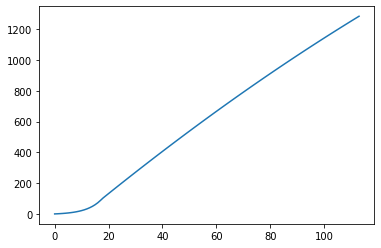

In [100]:
plt.plot(ypreds_ext[-2])

In [99]:
ypreds_ext[-2]

array([1.00000000e+00, 1.83042308e+00, 2.82154765e+00, 4.02263548e+00,
       5.45241928e+00, 7.16793646e+00, 9.22935849e+00, 1.17012092e+01,
       1.46693706e+01, 1.82265760e+01, 2.24982231e+01, 2.76165060e+01,
       3.37572530e+01, 4.11259890e+01, 4.99622926e+01, 6.05632988e+01,
       7.32757405e+01, 8.85241618e+01, 1.04742209e+02, 1.18780607e+02,
       1.32792505e+02, 1.46771728e+02, 1.60718276e+02, 1.74632150e+02,
       1.88513350e+02, 2.02361658e+02, 2.16176713e+02, 2.29958509e+02,
       2.43707045e+02, 2.57422322e+02, 2.71106070e+02, 2.84753336e+02,
       2.98367184e+02, 3.11947513e+02, 3.25494220e+02, 3.39007202e+02,
       3.52486299e+02, 3.65931376e+02, 3.79342320e+02, 3.92719018e+02,
       4.06061355e+02, 4.19369220e+02, 4.32642497e+02, 4.45881075e+02,
       4.59084839e+02, 4.72253676e+02, 4.85387473e+02, 4.98486116e+02,
       5.11549493e+02, 5.24577566e+02, 5.37570448e+02, 5.50528076e+02,
       5.63450379e+02, 5.76337285e+02, 5.89188723e+02, 6.02004620e+02,
      

In [96]:
lista_states

['Alabama',
 'Alaska',
 'Arizona',
 'Arkansas',
 'California',
 'Colorado',
 'Connecticut',
 'Delaware',
 'District of Columbia',
 'Florida',
 'Georgia',
 'Hawaii',
 'Idaho',
 'Illinois',
 'Indiana',
 'Iowa',
 'Kansas',
 'Kentucky',
 'Louisiana',
 'Maine',
 'Maryland',
 'Massachusetts',
 'Michigan',
 'Minnesota',
 'Mississippi',
 'Missouri',
 'Montana',
 'Nebraska',
 'Nevada',
 'New Hampshire',
 'New Jersey',
 'New Mexico',
 'New York',
 'North Carolina',
 'North Dakota',
 'Ohio',
 'Oklahoma',
 'Oregon',
 'Pennsylvania',
 'Rhode Island',
 'South Carolina',
 'South Dakota',
 'Tennessee',
 'Texas',
 'Utah',
 'Vermont',
 'Virginia',
 'Washington',
 'West Virginia',
 'Wisconsin',
 'Wyoming',
 'Puerto Rico']

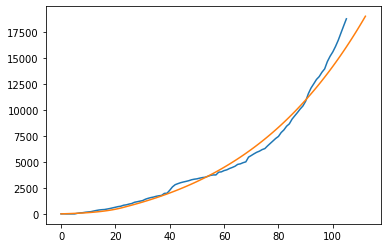

In [110]:
nonzero=np.array(confirmed[confirmed.Province_State==lista_states[3]].iloc[:,1:])
plt.plot(nonzero[nonzero>0])
plt.plot(ypreds_ext[3])

#### comparison Powell vs L-BFGS-B methods

In [ ]:
init_vals=[[0.25,0.25],[0.25,0.5],[0.25,0.75],[0.5,0.25],[0.5,0.5],[0.5,0.75],[0.75,0.25],[0.75,0.5],[0.75,0.75]]

In [ ]:
losses_p=np.array([np.zeros(len(Name2ab))]*len(init_vals))
betas_p=np.array([np.zeros(len(Name2ab))]*len(init_vals))
gammas_p=np.array([np.zeros(len(Name2ab))]*len(init_vals))

lista_pop=list(Population.values())
lista_states=list(Name2ab)

In [ ]:
for k in range(len(init_vals)):
    sirs=[None]*len(Name2ab)
    ys=[]
    xs=[]
    print('starting with {}-th initial values :{}'.format(k,init_vals[k]))
    for i in range(len(lista_states)):
        print(lista_pop[i])
        sirs[i]=SIR(lista_pop[i])
        print('starting collecting confirmed cases for state {}'.format(lista_states[i]))
        nonzero_arr=np.array(confirmed[confirmed.Province_State==lista_states[i]].iloc[:,1:])
        ys.append(nonzero_arr[nonzero_arr>0])
        xs.append(range(1,len(ys[i])+1))
        print('starts fitting for {}'.format(lista_states[i]))
        sirs[i].fit1(xs[i],ys[i],bnd=[(0.0001,0.99),(0.0001,0.99)],init_vals=init_vals[k],iters=300) 
        print('fitting done for state {}'.format(lista_states[i]))
        losses_p[k][i]=sirs[i].loss
        betas_p[k][i]=sirs[i].beta
        gammas_p[k][i]=sirs[i].gamma
 


In [ ]:
losses_l=np.array([np.zeros(len(Name2ab))]*len(init_vals))
betas_l=np.array([np.zeros(len(Name2ab))]*len(init_vals))
gammas_l=np.array([np.zeros(len(Name2ab))]*len(init_vals))

lista_pop=list(Population.values())
lista_states=list(Name2ab)

for k in range(len(init_vals)):
    sirs2=[None]*len(Name2ab)
    ys2=[]
    xs2=[]
    print('starting with {}-th initial values :{}'.format(k,init_vals[k]))
    for i in range(len(lista_states)):
        print(lista_pop[i])
        sirs2[i]=SIR(lista_pop[i])
        print('starting collecting confirmed cases for state {}'.format(lista_states[i]))
        nonzero_arr=np.array(confirmed[confirmed.Province_State==lista_states[i]].iloc[:,1:])
        ys2.append(nonzero_arr[nonzero_arr>0])
        xs2.append(range(1,len(ys2[i])+1))
        print('starts fitting for {}'.format(lista_states[i]))
        sirs2[i].fit1(xs2[i],ys2[i],bnd=[(0.0001,0.99),(0.0001,0.99)],init_vals=init_vals[k],mthd='L-BFGS-B',iters=300) 
        print('fitting done for state {}'.format(lista_states[i]))
        losses_l[k][i]=sirs2[i].loss
        betas_l[k][i]=sirs2[i].beta
        gammas_l[k][i]=sirs2[i].gamma

In [106]:
#with 30 distinct initial values
rnd.seed(123)
init_vals2=rnd.sample(range(10,9900),60)
betas20=[i/10000 for i in init_vals2[:30]]
gammas20=[i/10000 for i in init_vals2[30:]]
init_vals2=list(zip(betas20,gammas20)) 


losses_p2=np.array([np.zeros(len(Name2ab))]*len(init_vals2))
betas_p2=np.array([np.zeros(len(Name2ab))]*len(init_vals2))
gammas_p2=np.array([np.zeros(len(Name2ab))]*len(init_vals2))


#powell
for k in range(len(init_vals2)):
    sirs3=[None]*len(Name2ab)
    ys3=[]
    xs3=[]
    print('starting with {}-th initial values :{}'.format(k,list(init_vals2[k])))
    for i in range(len(lista_states)):
        print(lista_pop[i])
        sirs3[i]=SIR(lista_pop[i])
        print('starting collecting confirmed cases for state {}'.format(lista_states[i]))
        nonzero_arr=np.array(confirmed[confirmed.Province_State==lista_states[i]].iloc[:,1:])
        ys3.append(nonzero_arr[nonzero_arr>0])
        xs3.append(range(1,len(ys3[i])+1))
        print('starts fitting for {}'.format(lista_states[i]))
        sirs3[i].fit1(xs3[i],ys3[i],bnd=[(0.0001,0.99),(0.0001,0.99)],init_vals=list(init_vals2[k]),iters=300) 
        print('fitting done for state {}'.format(lista_states[i]))
        losses_p2[k][i]=sirs3[i].loss
        betas_p2[k][i]=sirs3[i].beta
        gammas_p2[k][i]=sirs3[i].gamma
#l-bfgs-b

losses_l2=np.array([np.zeros(len(Name2ab))]*len(init_vals2))
betas_l2=np.array([np.zeros(len(Name2ab))]*len(init_vals2))
gammas_l2=np.array([np.zeros(len(Name2ab))]*len(init_vals2))


for k in range(len(init_vals2)):
    sirs4=[None]*len(Name2ab)
    ys4=[]
    xs4=[]
    print('starting with {}-th initial values :{}'.format(k,list(init_vals2[k])))
    for i in range(len(lista_states)):
        print(lista_pop[i])
        sirs4[i]=SIR(lista_pop[i])
        print('starting collecting confirmed cases for state {}'.format(lista_states[i]))
        nonzero_arr=np.array(confirmed[confirmed.Province_State==lista_states[i]].iloc[:,1:])
        ys4.append(nonzero_arr[nonzero_arr>0])
        xs4.append(range(1,len(ys4[i])+1))
        print('starts fitting for {}'.format(lista_states[i]))
        sirs4[i].fit1(xs4[i],ys4[i],bnd=[(0.0001,0.99),(0.0001,0.99)],mthd='L-BFGS-B',init_vals=list(init_vals2[k]),iters=300) 
        print('fitting done for state {}'.format(lista_states[i]))
        losses_l2[k][i]=sirs4[i].loss
        betas_l2[k][i]=sirs4[i].beta
        gammas_l2[k][i]=sirs4[i].gamma

113

### Further work

daily betas per state:

$\beta_{i_c}=\frac{1}{\alpha}\sum_{\substack{j\neq i}} m_{ji}\frac{I_j}{\text{Pop}_j}$



In [ ]:
# mobility
data = pd.read_csv('../../Downloads/mobility/US_data/q2_2019.csv') # I miss name the file, it is quarter 1
matrix = data.groupby(['ORIGIN_STATE_ABR','DEST_STATE_ABR']).sum()['PASSENGERS'].unstack()


matrix.index.name='Abb'
matrix=matrix.fillna(0)
mijs=matrix.sum(axis=1) # including j=i
miis=[matrix.iloc[i,i] for i in range(matrix.shape[0])]
mijs_woi=list(map(lambda x,y:x-y,mijs,miis)) #m_ji for j \neq i
mijs_woi

dict(zip(matrix.index,mijs_woi))



states_df=pd.DataFrame({'Province_State':pd.Series(list(Name2ab)),'Abb':pd.Series(list(Name2ab.values()))})

c_mob=c[c['Province_State'].isin(list(Name2ab))].join(states_df.set_index('Province_State'),on='Province_State',how='inner')

pop_df=pd.DataFrame({'Abb':pd.Series(list(Population)),'Population':pd.Series(list(Population.values()))})

c_mob=c_mob.join(pop_df.set_index('Abb'),on='Abb').join(matrix,on='Abb',how='inner')

betas_mob=np.array([[0.0]*c_mob.shape[0]]*150) #150 dates from 01/22/20 to 06/19/20
for k in range(len(betas_mob)):
    for i in range(len(betas_mob[k])):
        for j in range(c_mob.shape[0]):
            if j==i:
                pass
            else:
                betas_mob[k][i]+=c_mob.iloc[j,153+i]*(c_mob.iloc[j,1+k]/c_mob.iloc[j,152])
    print('done with {}'.format(k))